## Airbnb Listing Price Prediction Model and Keyword Analysis

Group Members: Xueying(Alicia) Yang, Hongxia Shi, Yuwen Hong, Joseph Tsai, Sanchit Khatter

In [1]:
#import all library needed for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 1. Introduction

Airbnb is the most popular online hospitality platform that provides alternative accommodation options besides traditional hotels. It allows hosts to rent out their vacant space for tourism short-term stay. Airbnb gains the revenue from charging certain percentage of service from both parties on each confirmed reservation.


##### 1.1 Problem & Hypothesis

Unlike the competition of hotels, where the price of competitors is easy to find, it is hard for the Airbnb hosts to identify their competitor sets and the corresponding price. This would be a issue for the company, because without a fair price, the hosts are losing potential bookings, which then results in potential revenue loss for the company. Therefore, our team is hired to investigate in this issue and provide potential solutions.

The hypothesis is that attributes of the property play an important role in deciding the value of the listing. Therefore, we should be able to use the attibutes of a property as independent variables, and apply machine learning and regression knowledge to build a price prediction model, which will take the attributes from the hosts as input, and generate a benchmark price as output.

If we build this prediction model successfully, it could help the Airbnb hosts to set a more efficient price for their space, which will then increase hosts' revenue, and ultimately bring in more revenue to the company.

##### 1.2 Background and Related Works

During our research, we didn't find any published work using the same dataset. However, there are similar student projects done on other cities' Airbnb dataset, for example, San Francisco, New York, and etc. Most of them used linear regression, Ridge Regression and some other common regression models. Some of student projects only invested in certain variables to predict the price, for example, neighborhood. Text mining was also applied to some of the studies. In most of the studies, the students were able to build a model, using R-square, p-value, and t-value as the parameters to evaluate their model. 

In our analysis, besides the most commonly used 'least square' and 'ridge' model, we also added 'K-Nearest Neighbors (KNN)' model. And it seems the KNN model has the best performance. We also decided to take a different approach for evaluating our prediction result, which will be discussed in detail in the accuracy test section. Additionally, we also applied text mining to the description of each list and try to discover if there is any pattern of successful booking related to a group of key words we've selected. 

## 2. Dataset

The dataset is from “Inside Airbnb”, which provides listing information from different cities in the world. For this analysis, we’ve selected the dataset from Paris. The original dataset could be downloaded the link "http://insideairbnb.com/get-the-data.html"

In [2]:
# -------------------------------------------------------
# -------------- Getting The Original Data --------------
# -------------------------------------------------------

df_listing = pd.read_csv('listings.csv')

C:\Users\snowf\AppData\Local\Continuum\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (43,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 2.1 Data cleaning 

The initial dataset includes all listing information collected in Paris, France in 2017. The data set has 56536 rows and 95 columns. However, some of the columns are redundant or irrelevant.  Additionally, there are some empty cells under the important variable column for certain entries of the data. Given the condition of the initial dataset, in order to make our analysis result valid, we followed the following steps to clean up the dataset.


(1) Drop the columns that are irrelevant. 


(2) Drop the entries that has empty cells under important variable numerical columns, then set all price columns from $ to float.

In [3]:
# -------------------------------------------------------
# ------------------ Cleaning the Data ------------------
# -------------------------------------------------------

# according to the description of each features, we eliminate the following 
# features, which we think won't affect the price much.
# also, we eliminate the columns that the data is incomplete
# before elimination, we have 95 columns(include price)
# after elimination, we have 55 columns (include price)
cols_to_eliminate=["listing_url","scrape_id","last_scraped","experiences_offered", \
                   "thumbnail_url", "medium_url", "picture_url", "xl_picture_url", \
                   "host_id", "host_name", "host_url", "host_since", "host_response_time",\
                   "host_response_rate","host_acceptance_rate","host_thumbnail_url", \
                   "host_picture_url", "host_neighbourhood","host_total_listings_count",\
                   "host_verifications","neighbourhood_group_cleansed", "city", "state", \
                   "zipcode", "market", "smart_location", "country_code", "country", \
                   "is_location_exact","square_feet","calendar_updated","has_availability",\
                   "calendar_last_scraped", "first_review","last_review", "license", \
                   "jurisdiction_names", "calculated_host_listings_count",\
                   "neighbourhood",'street','host_listings_count','weekly_price','monthly_price']
print 'The original data shape: '
print '\n',df_listing.shape
df_listing.drop(cols_to_eliminate,axis=1,inplace = True)
print '\nAfter eliminating the columns with unmeaningful value, the df_listing.shape: '
print '\n',df_listing.shape


# eliminate the columns which has no value or value zero
# becaue we think these features are very import for price
# for example, the columns of bedrooms, beds and price 
df_listing = df_listing[df_listing.price != 0]
df_listing = df_listing[df_listing.bedrooms != 0]
df_listing = df_listing[df_listing.beds != 0]

# set the type of the vlues of column with symbol $ as float
cols_dollar = ["price","security_deposit","cleaning_fee",'extra_people']
for col in cols_dollar:
    df_listing[col] = df_listing[col].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)
    
# fill NA/NaN values
cols_fill_NaN = ["security_deposit","cleaning_fee"]
for col in cols_fill_NaN:
    df_listing[col] = df_listing[col].fillna(0,inplace=True)

    
# get the numerical columns
cols_numerical =[]
for col in df_listing.columns:
    if df_listing[col].dtype == 'int64' or df_listing[col].dtype == 'float64':
        cols_numerical.append(col)
# print cols_numerical
df_listing = df_listing.dropna(subset=cols_numerical)
print '\nAfter dropping the rows with null value for important columns, the data shape: '
print '\n',df_listing.shape

The original data shape: 

(56535, 95)

After eliminating the columns with unmeaningful value, the df_listing.shape: 

(56535, 52)

After dropping the rows with null value for important columns, the data shape: 

(32339, 52)


### 2.2 Data Exploration & Further Cleaning

After cleaning the data, we explored the basic distribution of the price and location in the whole dataset, then further looked into the categorical variables and invested their significance in the change of price by creating boxplots. 


##### Location Distribution

In [4]:
import folium
from folium import plugins

In [5]:
def convertfloat(x):
    try:
        x=float(x)
    except Exception:
        x = None
    return x
df_listing['latitude'] = df_listing['latitude'].apply(convertfloat)
df_listing['longitude']=df_listing['longitude'].apply(convertfloat)

In [6]:
df_maplisting=df_listing[np.isfinite(df_listing['longitude'])]
import random
heatmap_sample=df_listing.take(np.random.permutation(len(df_listing))[:1000])
listing_map=folium.Map(location=[48.864716,2.349014],zoom_start=11)
listing_map.add_children(plugins.HeatMap([[row['latitude'],row['longitude']]for name, row in heatmap_sample.iloc[:1000].iterrows()]))
listing_map.save('heatmapParis.html')
listing_map

##### Price Distribution with Location

In [7]:
# Calculating the quartiles of price
df_listing['price'].quantile([0.25,0.5,0.75]) 

0.25     57.0
0.50     80.0
0.75    119.0
Name: price, dtype: float64

In [8]:
# Making 4 different dataframes for segregating the data
final_1st=df_listing.loc[df_listing['price'] <60]        
final_2nd=df_listing.query('price >= 60 | price < 80')
final_3rd=df_listing.query('price >= 80 | price < 120')
final_4th=df_listing.loc[df_listing['price'] >120]

In each graph, colors indicate the amount of listing within a certain region 

In [9]:
# Making geographical representation of the listings in first price bucket
import folium
from folium import plugins
test = folium.Map(location = [48.8904555148, 2.32188906775], zoom_start = 4)
marker_cluster = folium.MarkerCluster().add_to(test)
for name, row in final_1st.iloc[:1000].iterrows():
    folium.Marker([row["latitude"], row["longitude"]]).add_to(marker_cluster)
test.save('test_1.html')
test

In [16]:
# Making geographical representation of the listings in second price bucket
test = folium.Map(location = [48.8904555148, 2.32188906775], zoom_start = 4)
marker_cluster = folium.MarkerCluster().add_to(test)
for name, row in final_2nd.iloc[:1000].iterrows():
    folium.Marker([row["latitude"], row["longitude"]]).add_to(marker_cluster)
test.save('test_1.html')
test

In [10]:
# Making geographical representation of the listings in third price bucket
test = folium.Map(location = [48.8904555148, 2.32188906775], zoom_start = 4)
marker_cluster = folium.MarkerCluster().add_to(test)
for name, row in final_3rd.iloc[:1000].iterrows():
    folium.Marker([row["latitude"], row["longitude"]]).add_to(marker_cluster)
test.save('test_1.html')
test

In [11]:
# Making geographical representation of the listings in fourth price bucket
test = folium.Map(location = [48.8904555148, 2.32188906775], zoom_start = 4)
marker_cluster = folium.MarkerCluster().add_to(test)
for name, row in final_4th.iloc[:1000].iterrows():
    folium.Marker([row["latitude"], row["longitude"]]).add_to(marker_cluster)
test.save('test_1.html')
test

As shown in the graph, most listings are located within the city center regardless of the price. However, the more expensive listings tend to locate near the North part of the city center(near the canal). This graph gives us an idea about how location can be related to the price of a Airbnb listings. Therefore, we should further study the degree this relationship and consider the location factor to refine our price model.

##### Price Distribution 

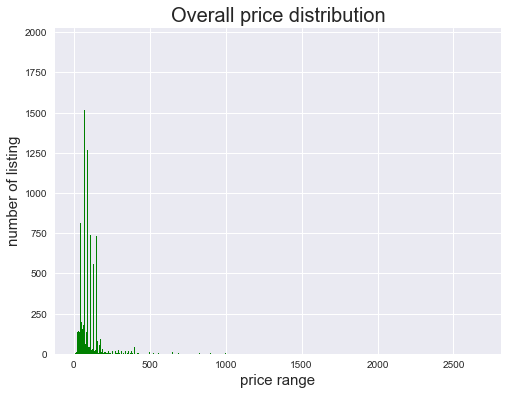

In [12]:
#overall price distribtuion with the original dataset
plt.figure(figsize=(8,6))
plt.hist(df_listing.price, bins=2000, color="g")

plt.xlabel('price range',fontsize=15)
plt.ylabel('number of listing',fontsize=15)
plt.title('Overall price distribution',fontsize=20)
plt.show()

From the overall price distribution above, we can see that the distritbution of this dataset is extremely right skewed, and there are outliers that has extremely high price. The main range of price is concentrated in the range of 0-$400

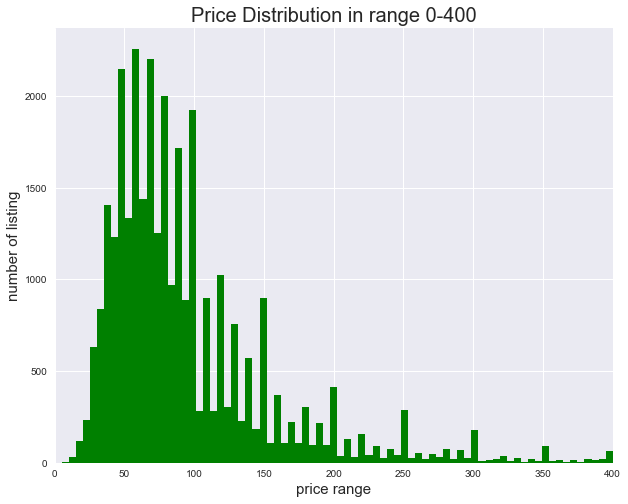

In [13]:
binbond=np.linspace(0,400,80)
plt.figure(figsize=(10,8))
plt.hist(df_listing.price, bins=binbond, color="g")

plt.xlim(0,400)
plt.xlabel('price range',fontsize=15)
plt.ylabel('number of listing',fontsize=15)
plt.title('Price Distribution in range 0-400',fontsize=20)
plt.show()

##### Categorical Variables

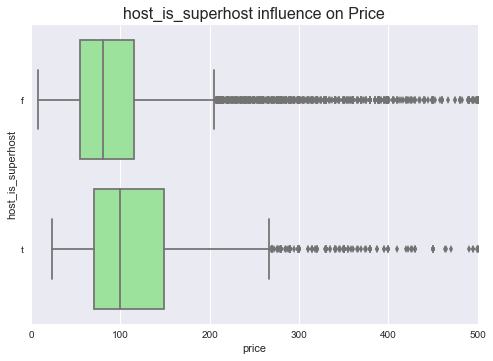

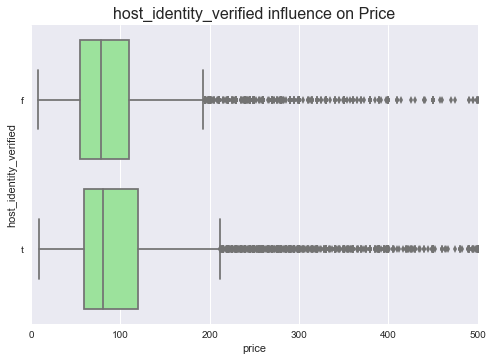

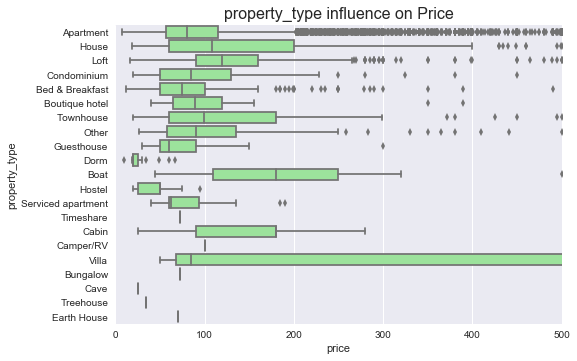

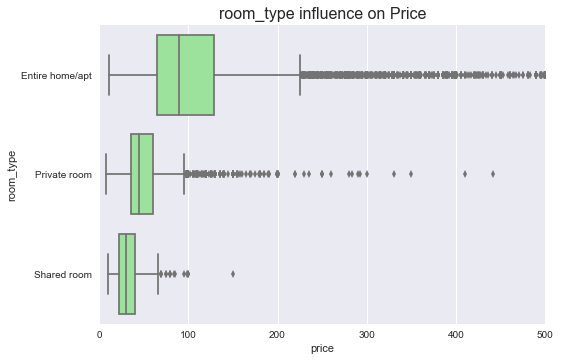

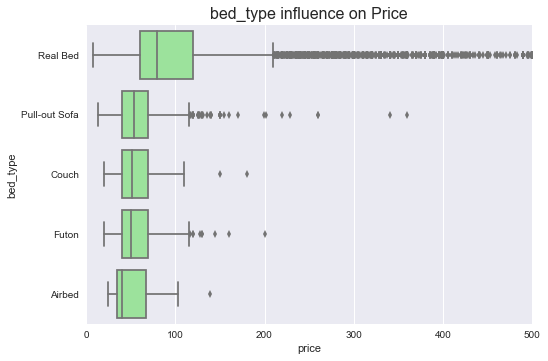

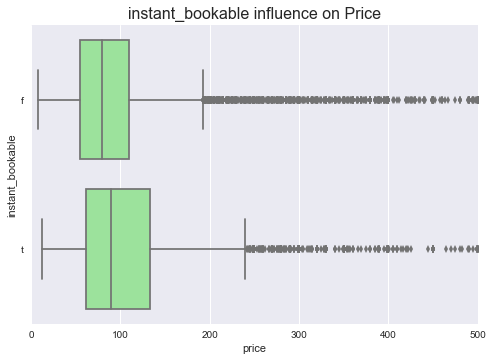

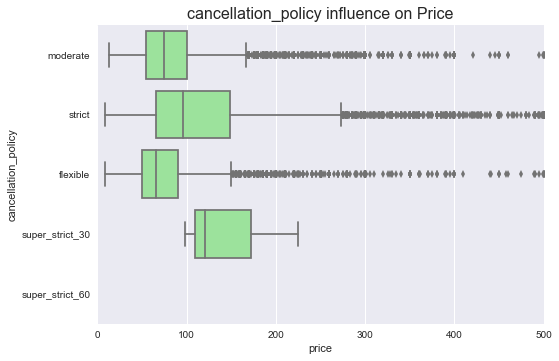

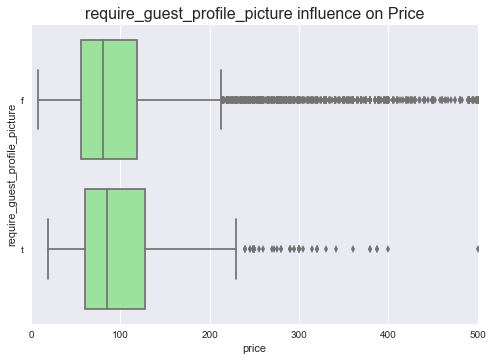

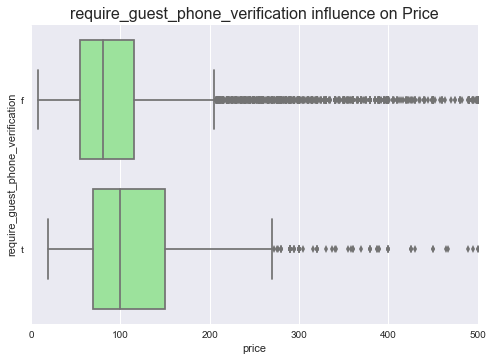

In [14]:
cat_cols=['host_is_superhost','property_type','room_type','cancellation_policy', 'instant_bookable','host_is_superhost', 'host_identity_verified', 'bed_type', 'require_guest_profile_picture', 'require_guest_phone_verification']
for cat in df_listing.columns:
    
    if cat in cat_cols:
        plt.figure()
        sns.boxplot(x='price', y=cat, data = df_listing, color ='lightgreen')
        plt.title('%s influence on Price'% cat, fontsize=16)
        plt.xlim(0,500)


##### Further Cleaning

From the price distribution, we can see that the majority of the data is within the range of $0-500 with some extreme outliers. From the boxplots, we can see that certain categorical variable has a major impact on the price. In order to increase our regression model’s accuracy and take categorical variables into consideration, we performed the following preprocess step on the dataset:

(3) Create dummy variables for the categorical columns. This allowed us to translate the string data into booleans. 

(4) Drop the data entries that are outside of the 3 standard deviation range.

In [15]:
# according to the content of columns with datatype of object
# get columns with category values, and transform them into dummy variables
cols_to_transform = ["host_is_superhost","host_has_profile_pic",\
                     "host_identity_verified","neighbourhood_cleansed",\
                     "property_type","room_type","bed_type","requires_license",\
                     "instant_bookable","cancellation_policy",\
                     "require_guest_profile_picture","require_guest_phone_verification"]
df_listing = pd.get_dummies( df_listing,columns = cols_to_transform)
print '\nAfter convering category variables into dummy variables, the data shape:'
print '\n',df_listing.shape

# eliminate the the rows with values, which are outliers
# according to the boxplot graphs, we can see that there are some outliers, which may
# affect the model we will create for price
cols_check_outliers = ['price', 'minimum_nights','maximum_nights']
for col in cols_check_outliers:
    df_listing = df_listing[np.abs(df_listing[col]-df_listing[col].mean()) <= (3*df_listing[col].std())]
print '\nAfter dropping outliers, the data shape:'
print '\n',df_listing.shape



After convering category variables into dummy variables, the data shape:

(32339, 107)

After dropping outliers, the data shape:

(31803, 107)


### 2.3 Split data

After cleaning the original dataset, we’ve randomly selected 80% of the data as training data to build the regression model on, and the remaining 20% will be used to test our regression model for accuracy. 

Without the test data, it is possible that the model is overfitted to this specific dataset, and there is no way for us to discover this flaw. Running the test data through the model is an effective method to evaluate our model on real listings.

In [16]:
#Note: The split data is included in your data package. 
#Please refer to X_train.csv, Y_train.csv, X_test.csv, Y_test.csv
# -------------------------------------------------------
# ------------------ Spliting The Data ------------------
# -------------------------------------------------------

# # get the all the observations of Y(price)
# Y = df_listing.loc[:, ['price']]


# # get all all the observations of all variables
# X = df_listing.drop('price', 1)

# # split the all the data into training and test data
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# # save the files split data
# X_train.to_csv('X_train.csv',index=False)
# X_test.to_csv('X_test.csv',index=False)
# Y_train.to_csv('Y_train.csv',index=False)
# Y_test.to_csv('Y_test.csv',index=False)

## 3. Validating Assumption: Price affects booking choice

Price was assumed to be the cause of the low booking rates. To further investigate this issue, we drew a bar chart of booking rates by price to visualize and explore if there are obvious correlation between price and booking rate.

### 3.1 Incorporate calendar and booking data

In [17]:
# Reading the calendar file for bookings
cal=pd.read_csv("calendar.csv")  
# Deleting the price column as we don't need it
del cal['price']                 
# Creating a pivot table to calculate total booking days and their break-up
cal1=pd.pivot_table(cal,index=['listing_id'],columns=['available'],aggfunc='count') 

KeyboardInterrupt: 

In [ ]:
cal1.columns = cal1.columns.droplevel()   # Dropping the multi-level column headings
cal1 = cal1.reset_index()                 # Reseting the columns
cal1['total']=cal1['f']+cal1['t']         # Adding a new column with total days of listing
cal1['perc']=cal1['f']/cal1['total']      # Calcultaing the percentage of total booked days

In [ ]:
columns2=['id',"beds","bathrooms","minimum_nights","number_of_reviews","review_scores_rating","latitude","longitude"]
X_train=pd.read_csv('X_train.csv',usecols=columns2)
Y_train=pd.read_csv('Y_train.csv')  # Reading the file with all the train data

df_listing=pd.merge(X_train,Y_train,left_index=True,right_index=True)
df_listing.dropna(subset=columns2)                                  # Droppping all the NA Values if any
df_listing.rename(columns={'id': 'listing_id'}, inplace=True)      # Renaming the column name to listing Id for coherence

In [ ]:
final=pd.merge(df_listing,cal1,on='listing_id',how='inner')# Merging the 2 dataframes
final.head(3)

Divided the listing data into 4 equal sets based on lisitng price.

In [ ]:
final=final.dropna()
final=final[final.columns[1:]].replace('[\$,]', '', regex=True).astype(float)   # Replacing the $ sign
bins = [0,60,80,120,400]                                                       # Making Price bins for the graph
group_names = ['Low Price', 'Medium Price', 'High Price', 'Very High Price']    # Tagging them as shown on te left
final['price_bucket'] = pd.cut(final['price'], bins, labels=group_names)        # Adding a column with the bins
final.dropna()

In [ ]:
final1 = final.groupby("price_bucket", as_index=False).perc.mean()  # Calculating the mean booking percentage for all the bins
final1["perc"]=final1["perc"]*100
final2 = pd.DataFrame(final1)                                       # Converting it into a dataframe
final2=final2.sort_index(by=['perc'], ascending=[False])            # Sorting the index
final2 = pd.DataFrame(final1)
final2['price_bucket'] = pd.Categorical(final2['price_bucket'])     # Making the column values as categorical

In [ ]:
import seaborn as sns
sns.barplot(x="price_bucket", y="perc", data=final2 , order = ['Low Price', 'Medium Price', 'High Price', 'Very High Price'])
sns.plt.show()  # Plotting a bar graph for price bucket against mean booking ratio

### 3.2 Results of the Graph: 
The horizontal axis represent the price from low to high, and vertical axis represent the booking rates, whcih is days booked/(days booked+days available). A obvious trend can be observed from this graph. As the price of the Airbnb listings increases the booking rates decreases from 55% to 40%. Therefore, the main trend of our data suggest that the higher priced listings are likely to have lower booking rates in general.

## 4. Prediction Model 

### 4.1 Variable Selection

To build the regression model, we first separate the variables from the text information.

In [18]:
# -------------------------------------------------------
# ---------- Loading The training and test Data ---------
# -------------------------------------------------------

# import training data
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('Y_train.csv')

# import test data
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('Y_test.csv')

# merge the independent and dependent variables 
df_listing = pd.concat([y_train, X_train], axis=1)

# print X_train.shape
# print y_train.head()
# print X_test.head()
# print y_test.head()
# print X_train.columns
# print X_train.describe()
# df_listing

In [19]:
# -------------------------------------------------------
# ---------- Cleaning The training and test Data --------
# -------------------------------------------------------

# eliminate columns with string datatype
cols_text=["name","summary","space","description","neighborhood_overview","notes",\
           "transit","access","interaction","house_rules","host_location","host_about","amenities"]
X_train_0 = X_train.drop(cols_text, axis=1)
X_test_0 = X_test.drop(cols_text, axis=1)
print 'After eliminating columns with string datatype, the training data shape:'
print '\n',X_train_0.shape
print '\nAfter eliminating columns with string datatype, the test data shape:'
print '\n',X_test_0.shape

After eliminating columns with string datatype, the training data shape:

(25442, 93)

After eliminating columns with string datatype, the test data shape:

(6361, 93)


variable:  id


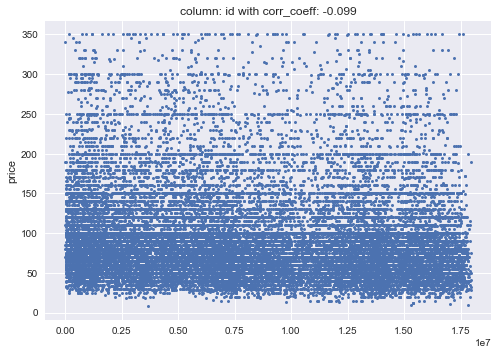

variable:  latitude


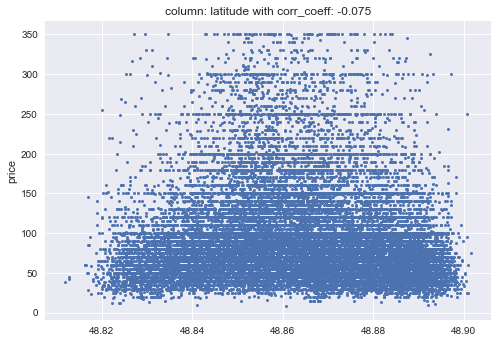

variable:  longitude


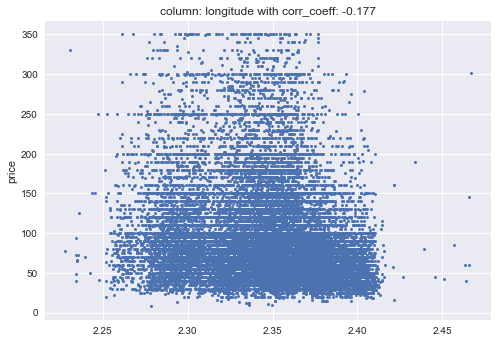

variable:  accommodates


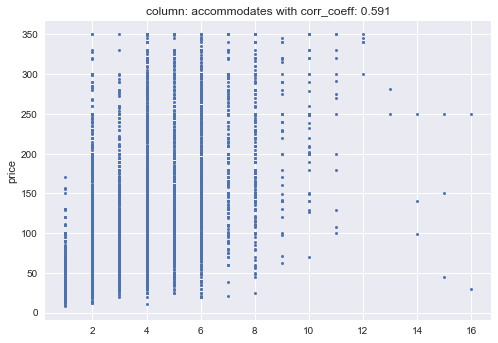

variable:  bathrooms


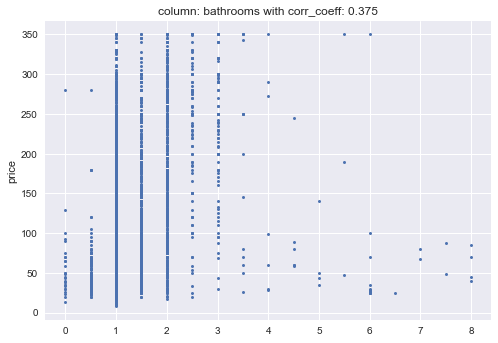

variable:  bedrooms


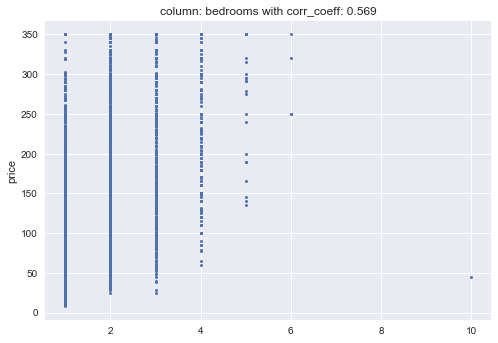

variable:  beds


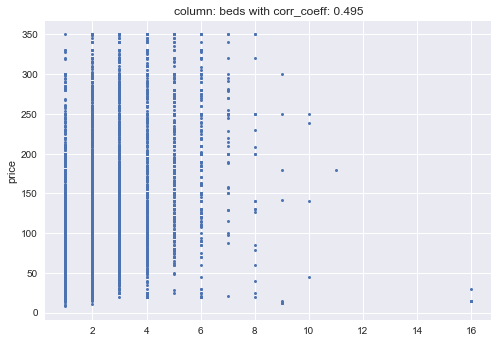

variable:  security_deposit


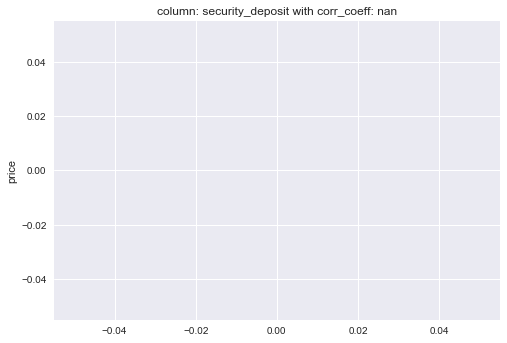

variable:  cleaning_fee


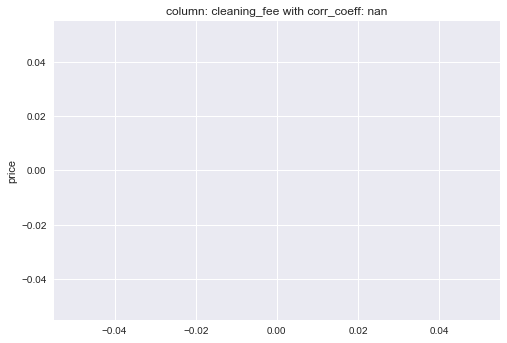

variable:  guests_included


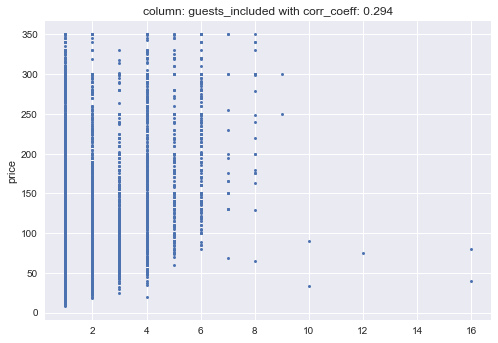

variable:  extra_people


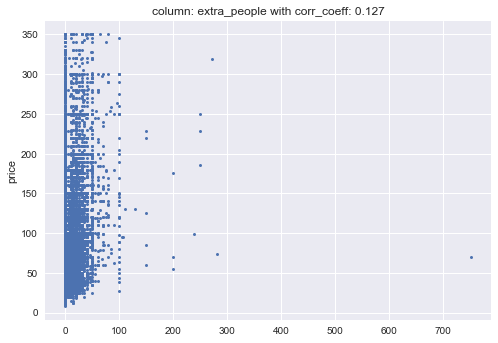

variable:  minimum_nights


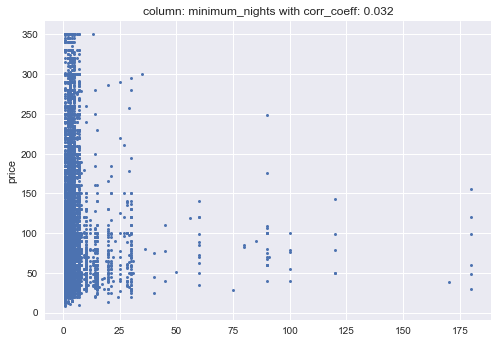

variable:  maximum_nights


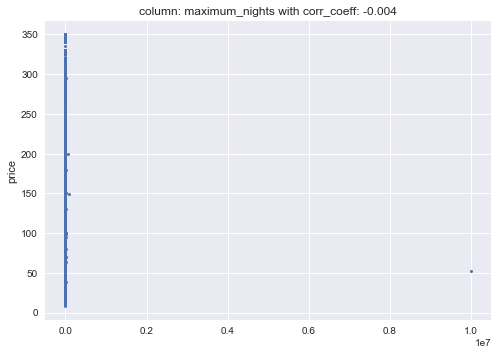

variable:  availability_30


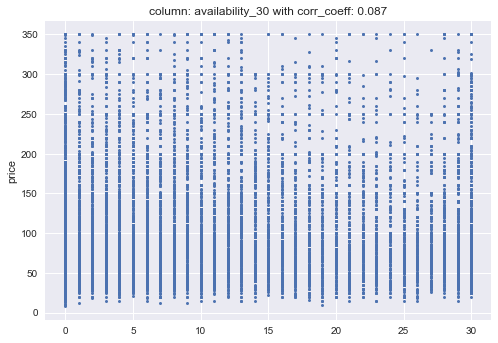

variable:  availability_60


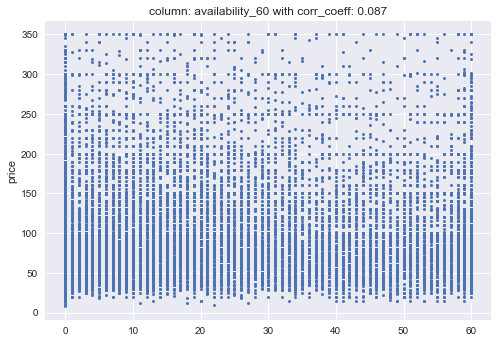

variable:  availability_90


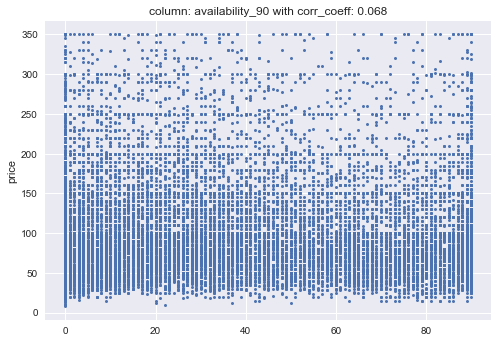

variable:  availability_365


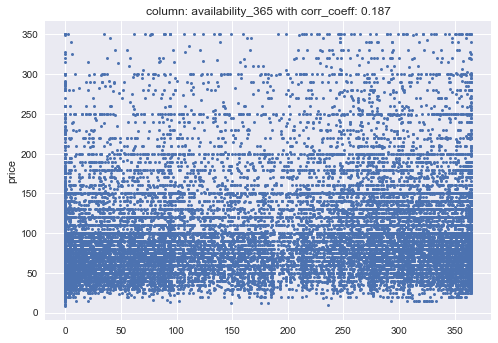

variable:  number_of_reviews


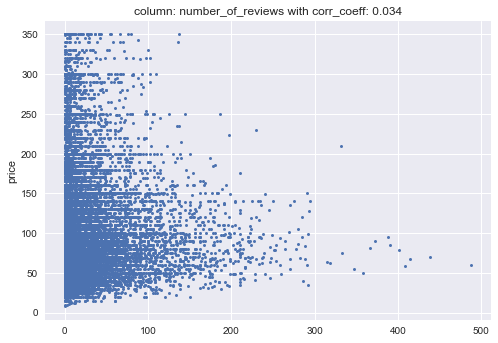

variable:  review_scores_rating


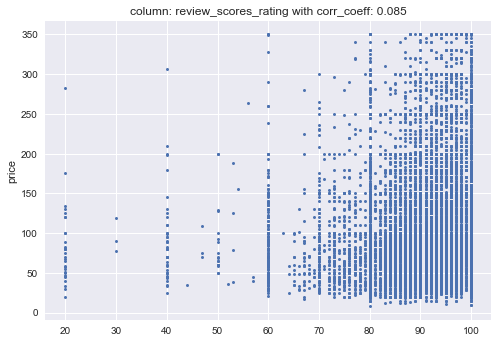

variable:  review_scores_accuracy


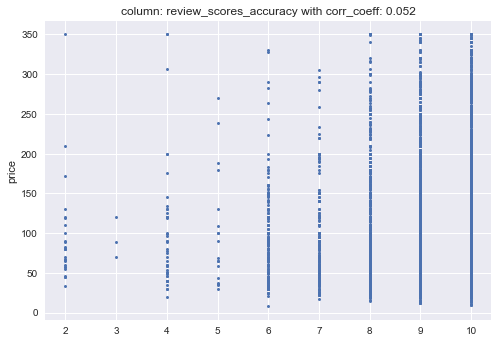

variable:  review_scores_cleanliness


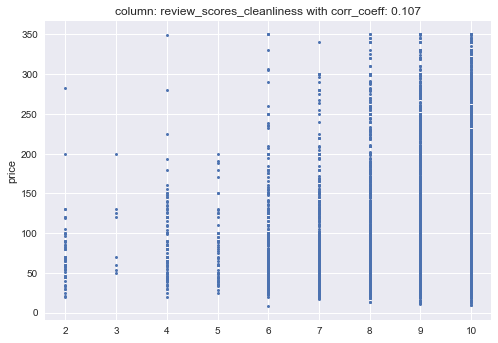

variable:  review_scores_checkin


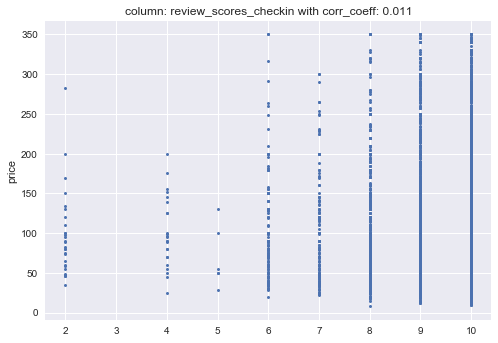

variable:  review_scores_communication


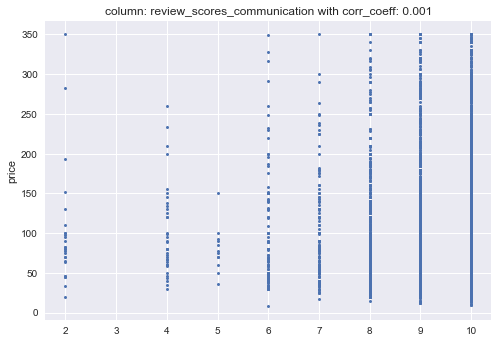

variable:  review_scores_location


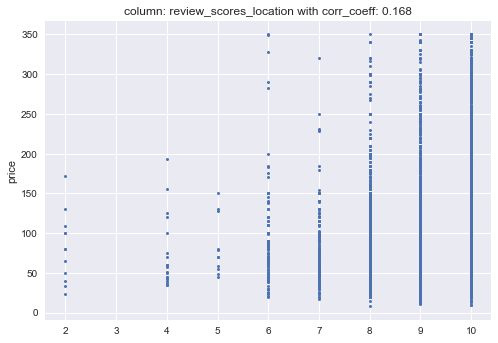

variable:  review_scores_value


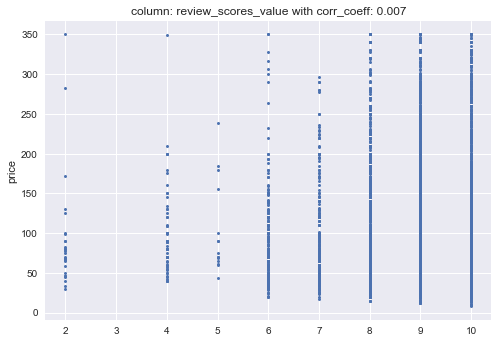

variable:  reviews_per_month


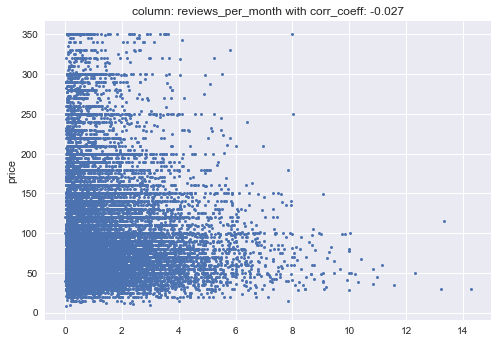

variable:  host_is_superhost_f


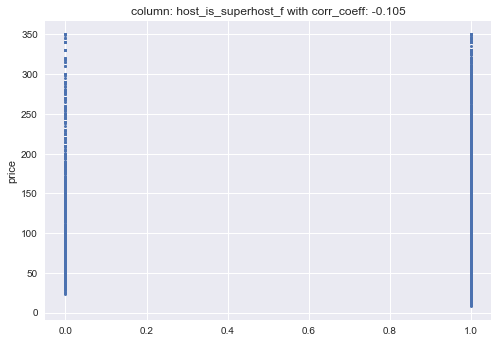

variable:  host_is_superhost_t


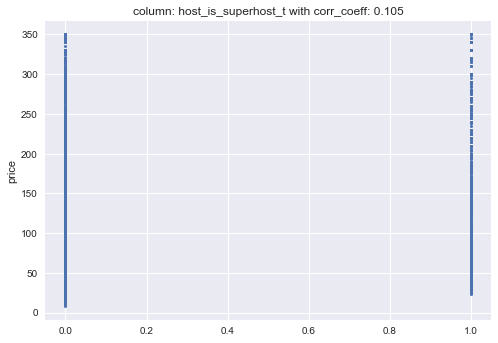

variable:  host_has_profile_pic_f


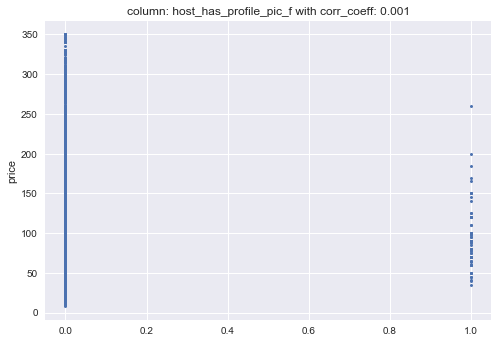

variable:  host_has_profile_pic_t


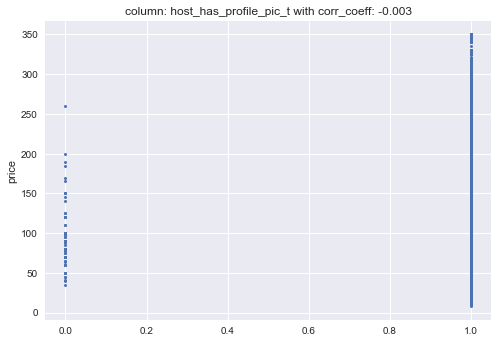

variable:  host_identity_verified_f


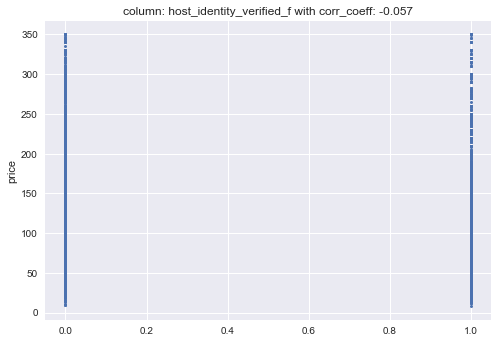

variable:  host_identity_verified_t


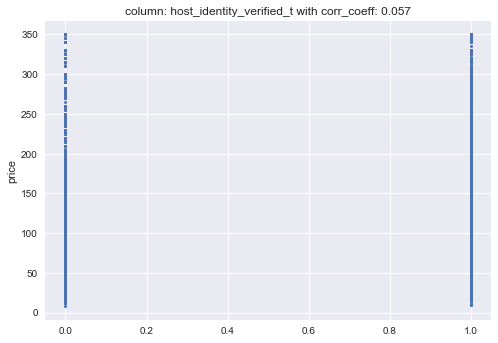

variable:  neighbourhood_cleansed_Batignolles-Monceau


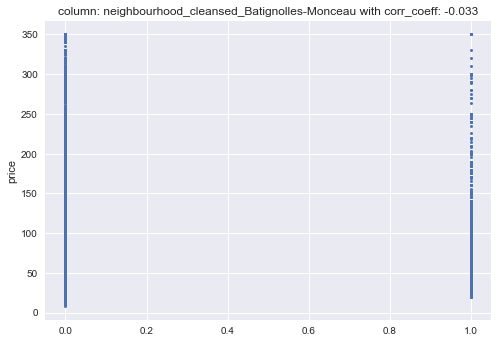

variable:  neighbourhood_cleansed_Bourse


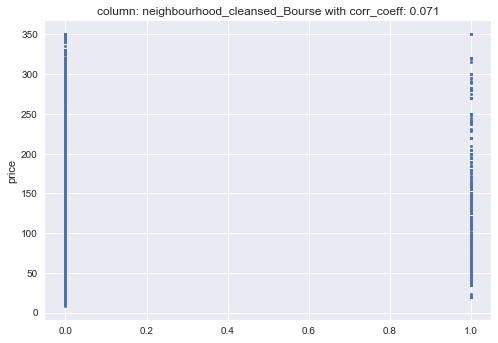

variable:  neighbourhood_cleansed_Buttes-Chaumont


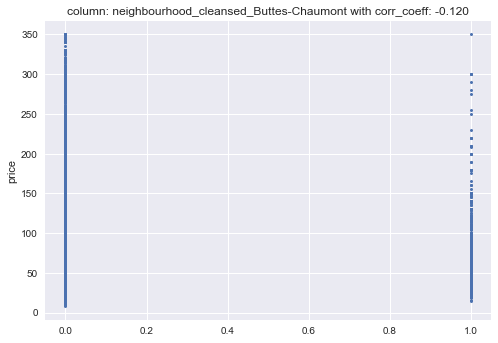

variable:  neighbourhood_cleansed_Buttes-Montmartre


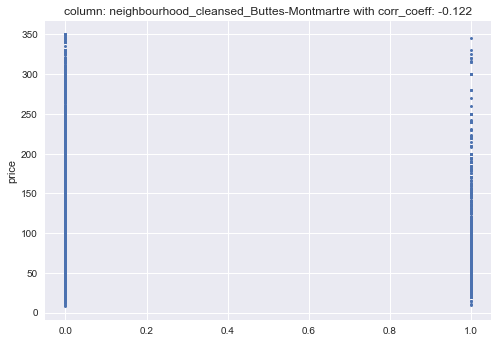

variable:  neighbourhood_cleansed_Entrepôt


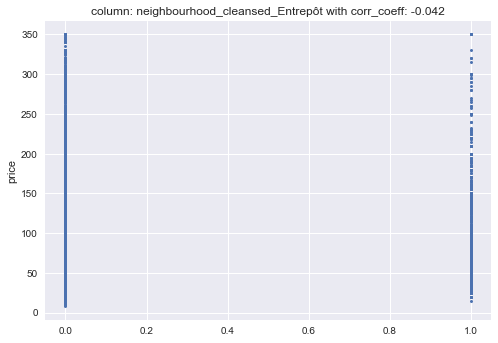

variable:  neighbourhood_cleansed_Gobelins


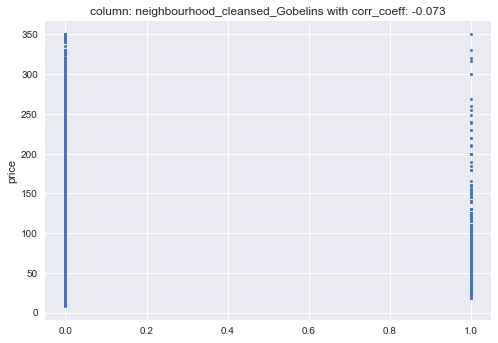

variable:  neighbourhood_cleansed_Hôtel-de-Ville


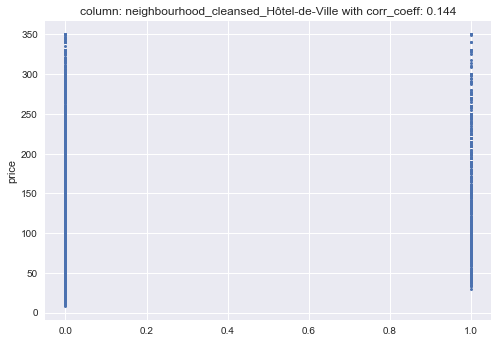

variable:  neighbourhood_cleansed_Louvre


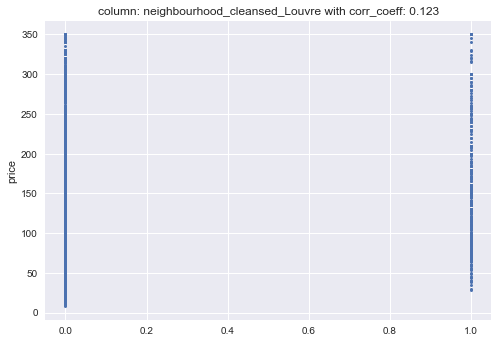

variable:  neighbourhood_cleansed_Luxembourg


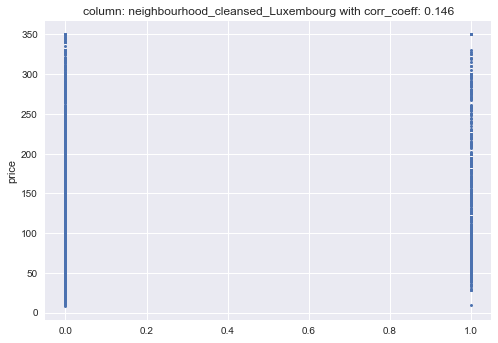

variable:  neighbourhood_cleansed_Ménilmontant


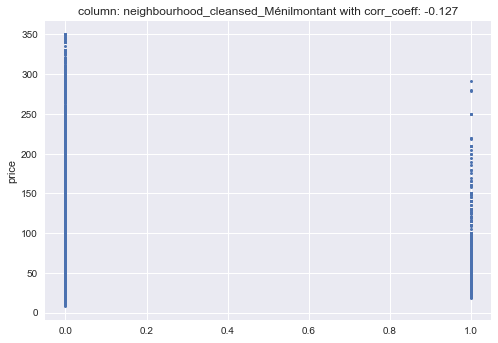

variable:  neighbourhood_cleansed_Observatoire


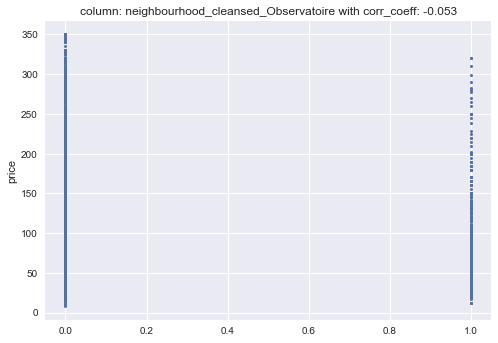

variable:  neighbourhood_cleansed_Opéra


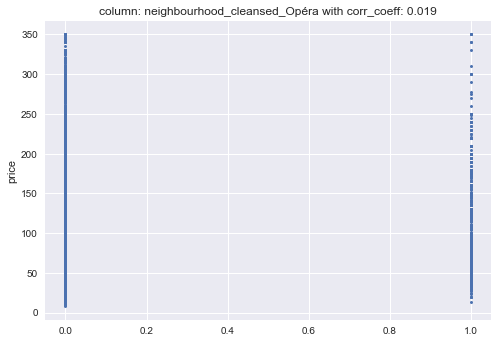

variable:  neighbourhood_cleansed_Palais-Bourbon


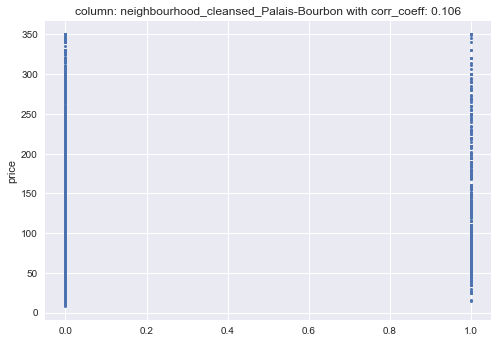

variable:  neighbourhood_cleansed_Panthéon


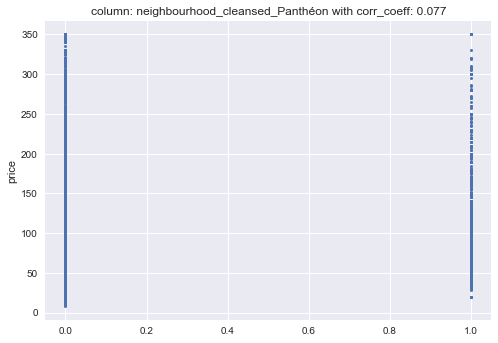

variable:  neighbourhood_cleansed_Passy


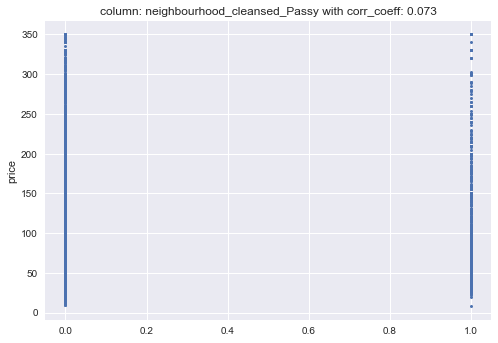

variable:  neighbourhood_cleansed_Popincourt


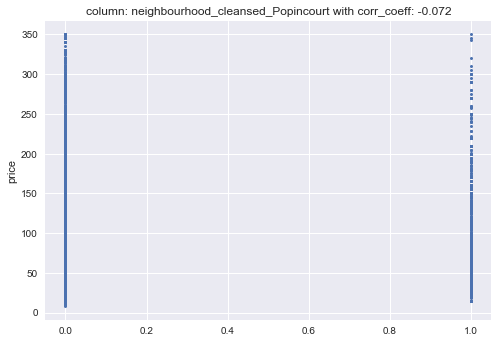

variable:  neighbourhood_cleansed_Reuilly


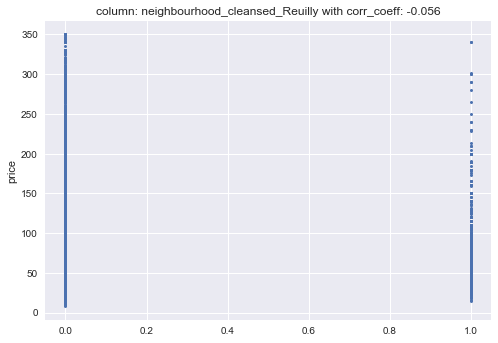

variable:  neighbourhood_cleansed_Temple


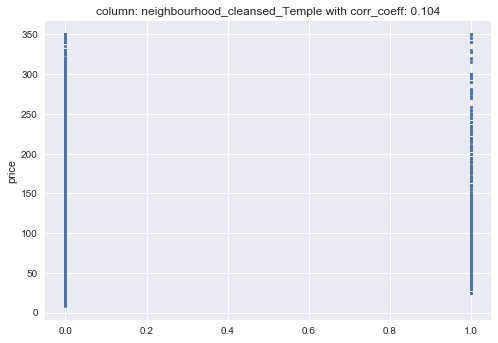

variable:  neighbourhood_cleansed_Vaugirard


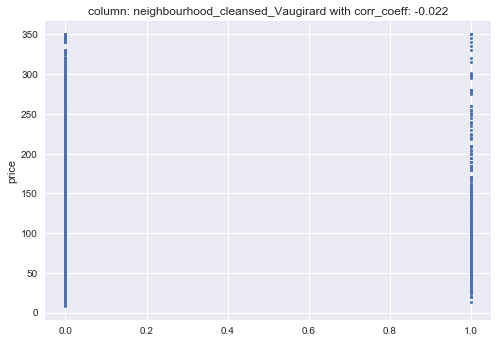

variable:  neighbourhood_cleansed_Élysée


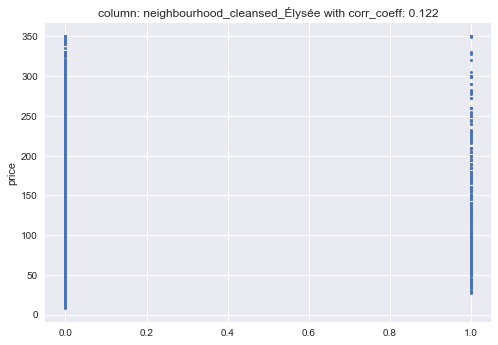

variable:  property_type_Apartment


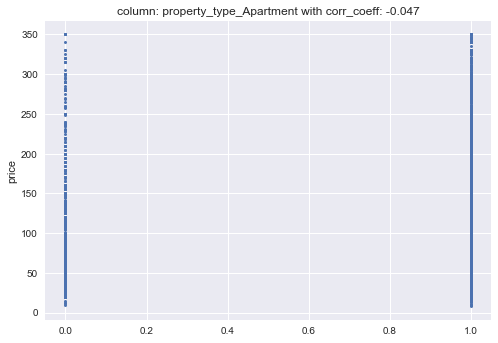

variable:  property_type_Bed & Breakfast


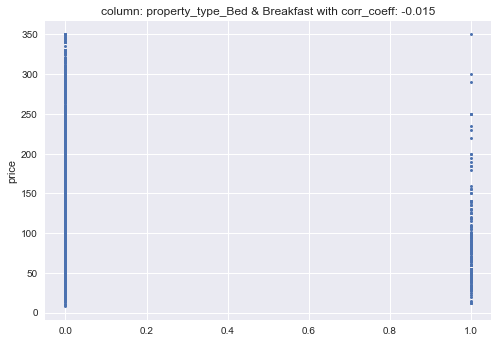

variable:  property_type_Boat


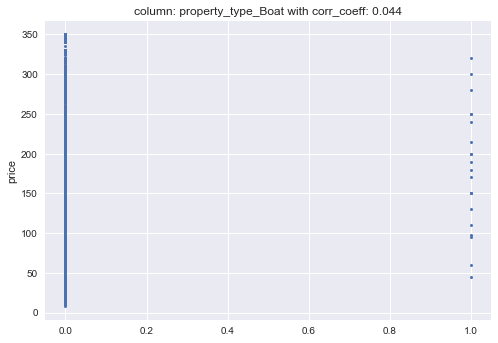

variable:  property_type_Boutique hotel


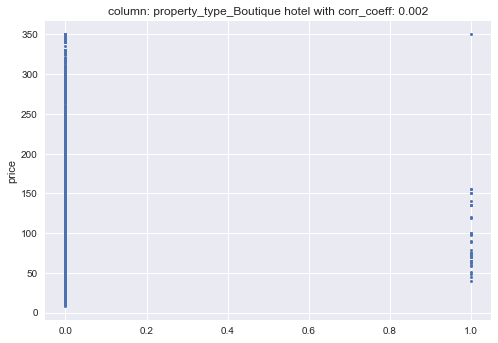

variable:  property_type_Bungalow


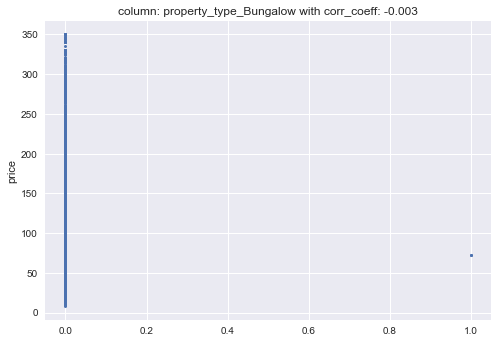

variable:  property_type_Cabin


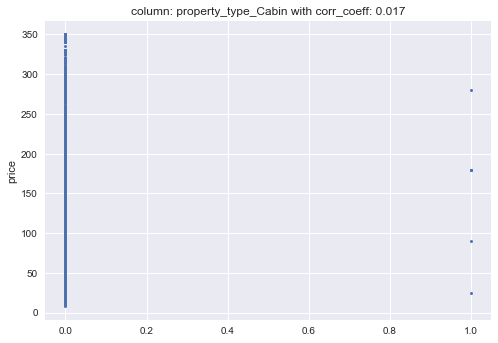

variable:  property_type_Camper/RV


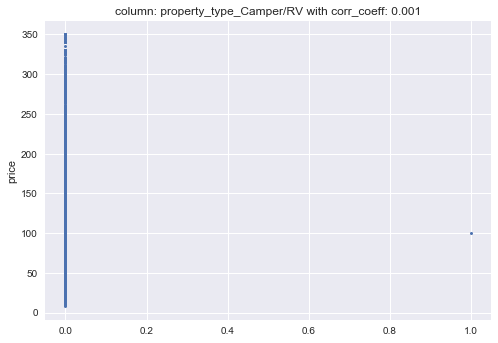

variable:  property_type_Cave


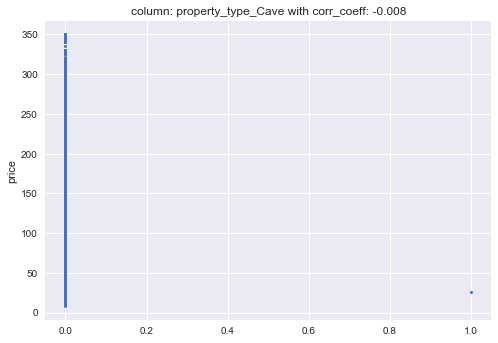

variable:  property_type_Condominium


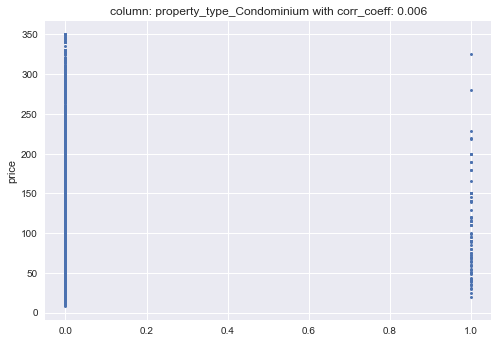

variable:  property_type_Dorm


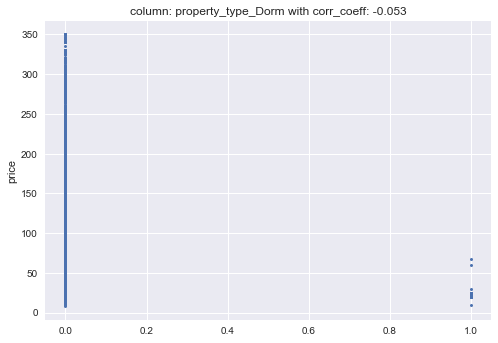

C:\Users\snowf\AppData\Local\Continuum\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\snowf\AppData\Local\Continuum\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


variable:  property_type_Earth House


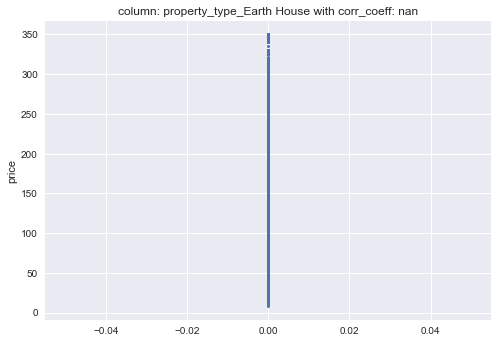

variable:  property_type_Guesthouse


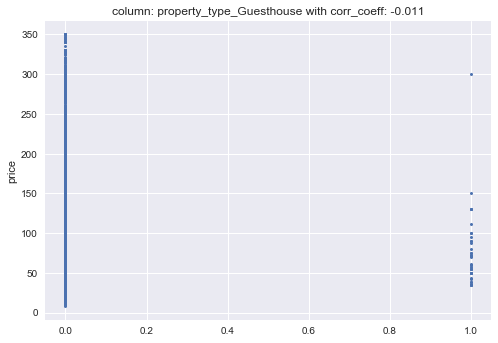

variable:  property_type_Hostel


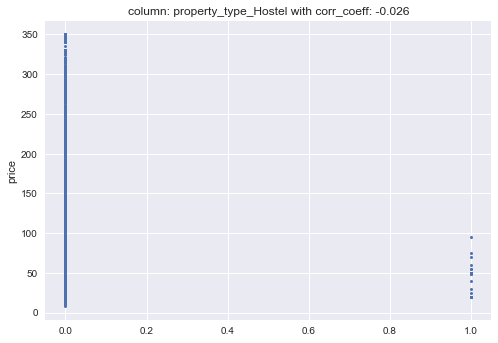

variable:  property_type_House


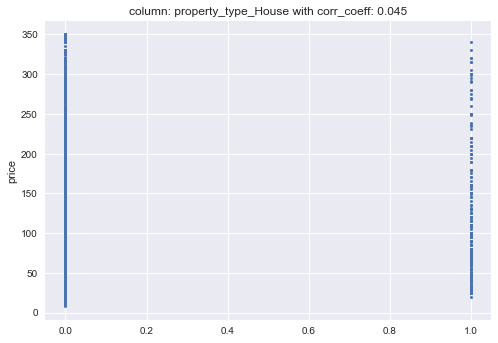

variable:  property_type_Loft


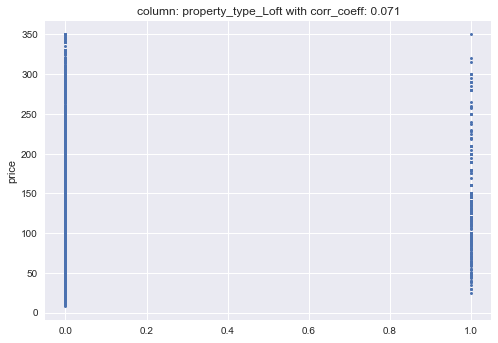

variable:  property_type_Other


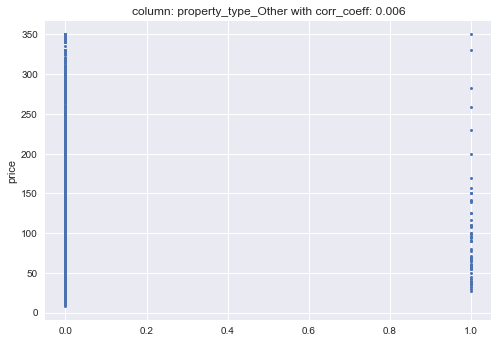

variable:  property_type_Serviced apartment


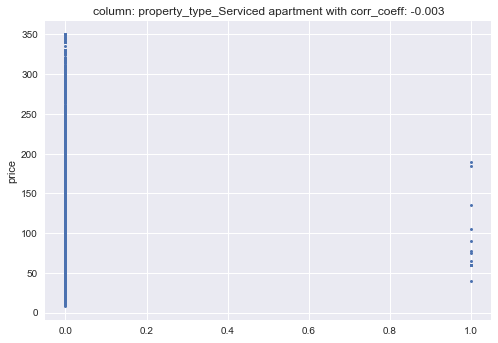

variable:  property_type_Timeshare


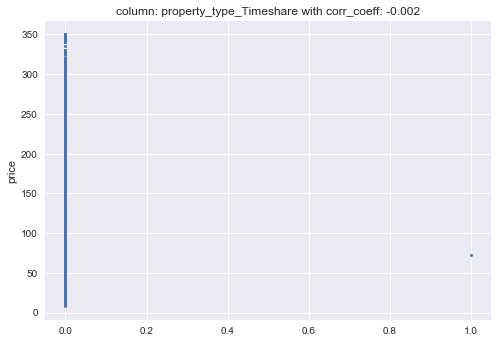

variable:  property_type_Townhouse


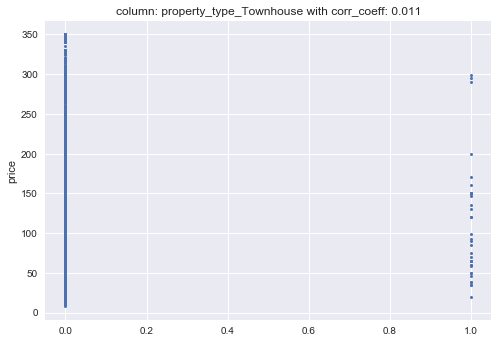

variable:  property_type_Treehouse


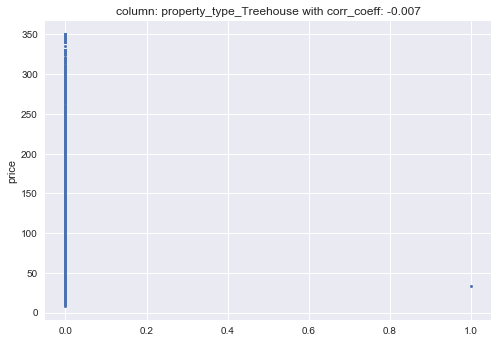

variable:  property_type_Villa


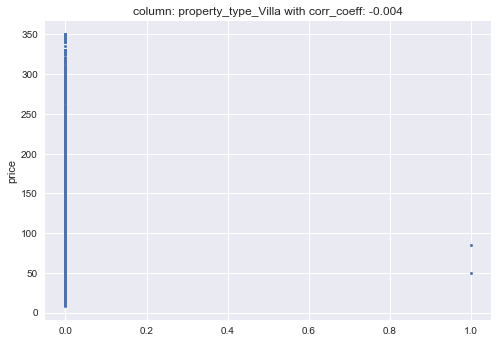

variable:  room_type_Entire home/apt


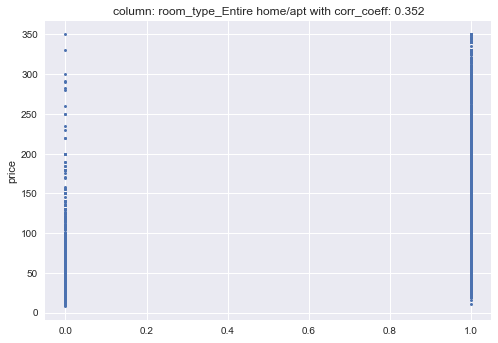

variable:  room_type_Private room


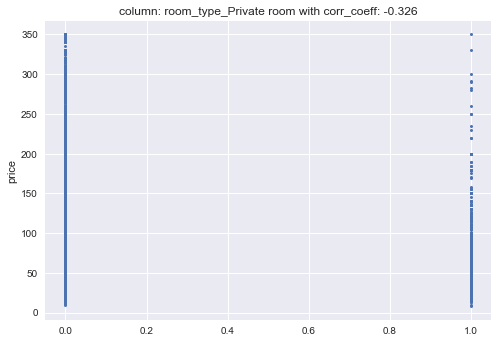

variable:  room_type_Shared room


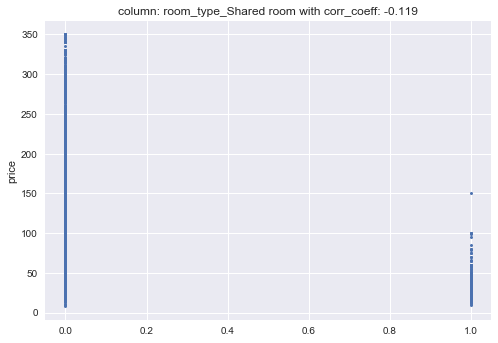

variable:  bed_type_Airbed


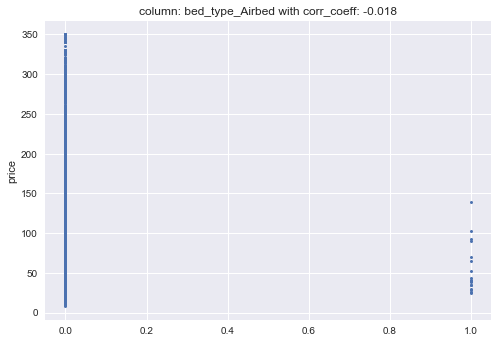

variable:  bed_type_Couch


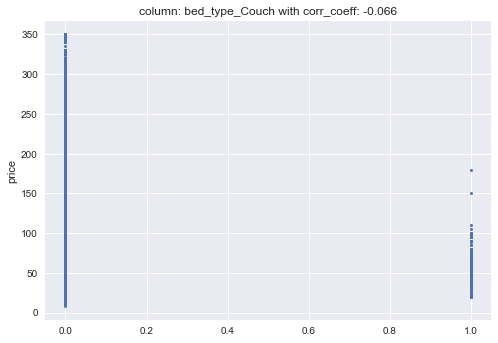

variable:  bed_type_Futon


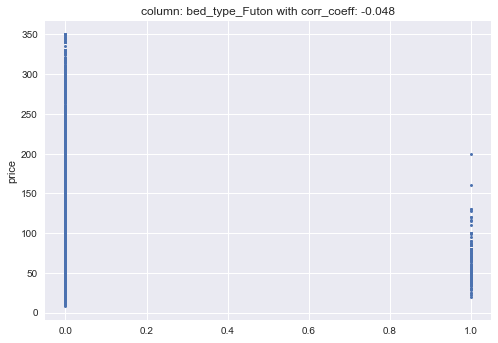

variable:  bed_type_Pull-out Sofa


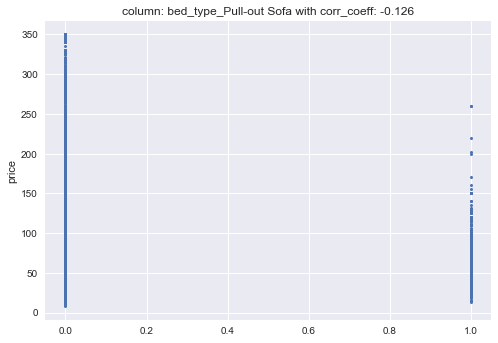

variable:  bed_type_Real Bed


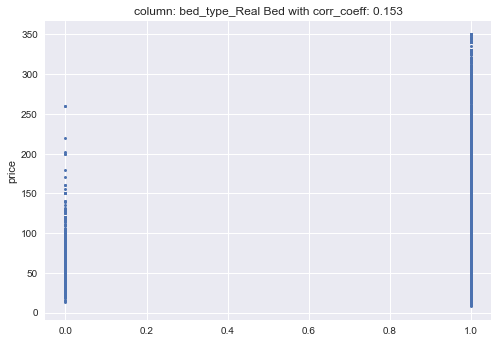

variable:  requires_license_f


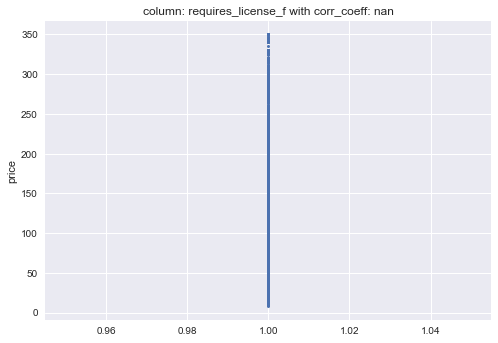

variable:  instant_bookable_f


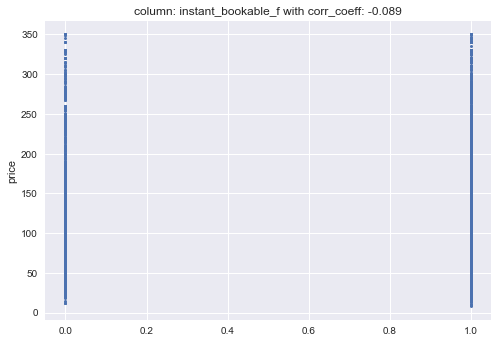

variable:  instant_bookable_t


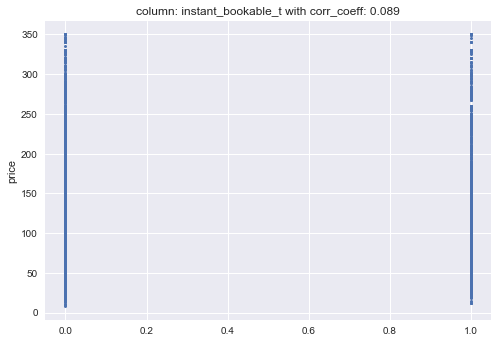

variable:  cancellation_policy_flexible


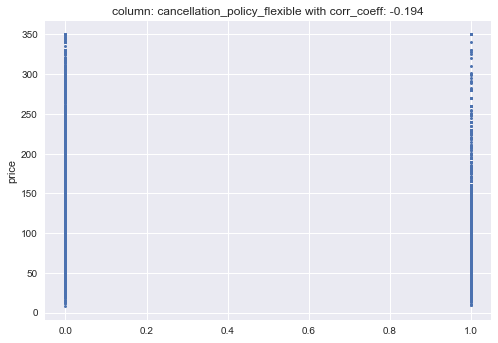

variable:  cancellation_policy_moderate


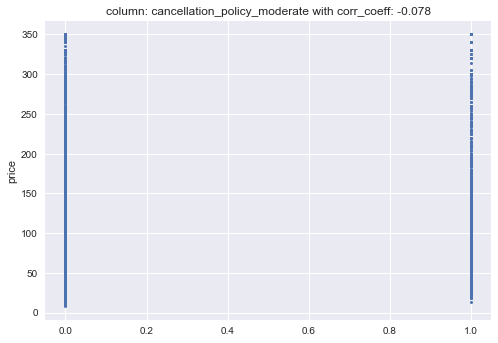

variable:  cancellation_policy_strict


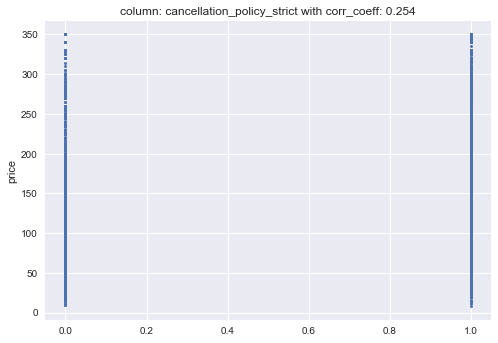

variable:  cancellation_policy_super_strict_30


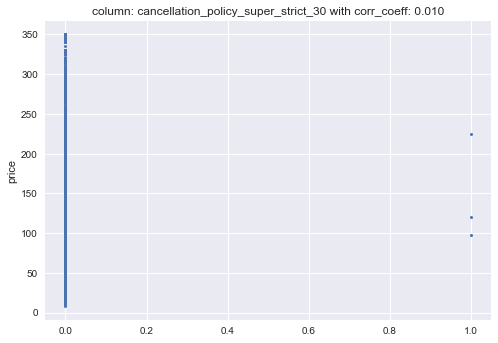

variable:  cancellation_policy_super_strict_60


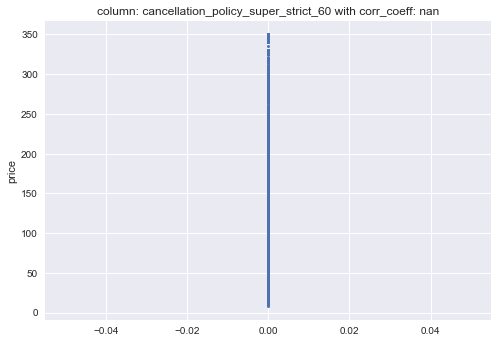

variable:  require_guest_profile_picture_f


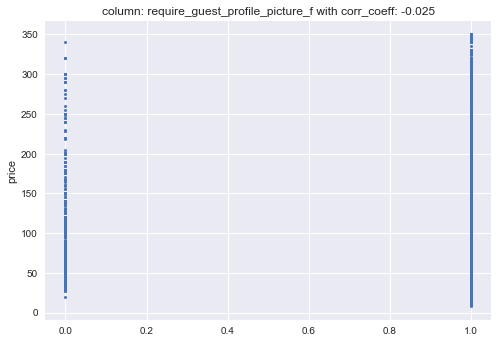

variable:  require_guest_profile_picture_t


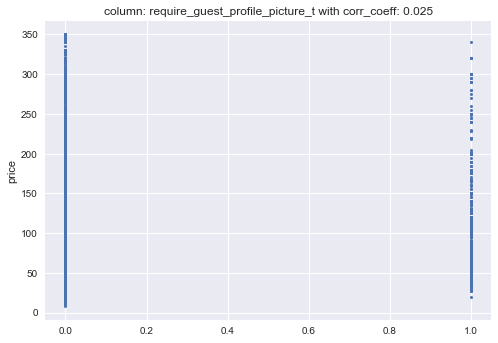

variable:  require_guest_phone_verification_f


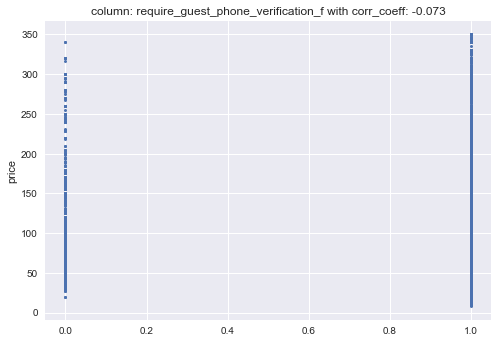

variable:  require_guest_phone_verification_t


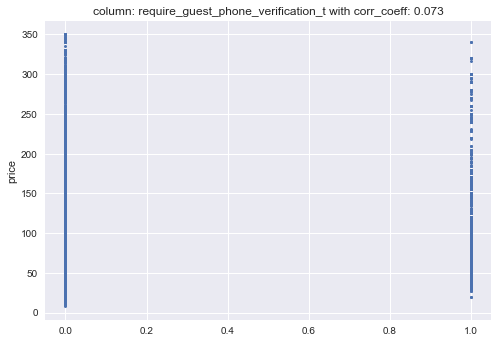

In [20]:
# plot price - each feature in train data
# also, calculate the correlation coefficient between each variable and price 
for column in X_train_0.columns:
    if np.issubdtype(X_train_0[column].dtype, np.number):
        corr_coeff = np.corrcoef(X_train_0[column].values, y_train.values.ravel())[0,1]
        print 'variable: ', column
        plt.figure()
        plt.plot(X_train_0[column], y_train,'o', markersize=3)
        plt.title('column: %s with corr_coeff: %.3f' % (column.decode('utf8'), corr_coeff))
        plt.ylabel('price')
        plt.show()

After looking at the scatter plot graphs between each feature and price, we found out that the price is more likely to be related to the following variables: 

latitude, longitude, accommodates, bathrooms, 
bedrooms, beds, guests_included, extra_people, 
minimum_nights, number_of_reviews, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin,review_scores_communication, review_scores_location, review_scores_value, reviews_per_month, host_has_profile_pic_f, host_has_profile_pic_t, neighbourhood_cleansed_Buttes-Chaumont, neighbourhood_cleansed_Ménilmontant, neighbourhood_cleansed_Reuilly, property_type_Bed & Breakfast, property_type_Boat, property_type_Boutique hotel, property_type_Bungalow, property_type_Dorm, property_type_Guesthouse, property_type_Hostel, property_type_Serviced apartment, room_type_Entire home/apt, room_type_Private room, room_type_Shared room, bed_type_Airbed, bed_type_Couch, bed_type_Futon, bed_type_Pull-out Sofa, bed_type_Real Bed

In [21]:
# eliminate the variables, which are less likely to affect the listing price
cols_related = [u'latitude', u'longitude', u'accommodates', u'bathrooms',
       u'bedrooms', u'beds', u'guests_included', u'extra_people',
       u'minimum_nights', u'number_of_reviews', u'review_scores_rating',
       u'review_scores_accuracy', u'review_scores_cleanliness',
       u'review_scores_checkin', u'review_scores_communication',
       u'review_scores_location', u'review_scores_value', u'reviews_per_month',
       u'host_has_profile_pic_f', u'neighbourhood_cleansed_Buttes-Chaumont', u'neighbourhood_cleansed_Reuilly',
       u'property_type_Apartment', u'property_type_Bed & Breakfast', u'property_type_Boat',
       u'property_type_Boutique hotel', u'property_type_Bungalow',
       u'property_type_Dorm', u'property_type_Guesthouse', u'property_type_Hostel',
       u'property_type_Serviced apartment', u'room_type_Entire home/apt',
       u'room_type_Private room', u'room_type_Shared room', u'bed_type_Airbed',
       u'bed_type_Couch', u'bed_type_Futon', u'bed_type_Pull-out Sofa',
       u'bed_type_Real Bed']

X_train_0 = X_train_0.loc[:, cols_related]
X_test_0 = X_test_0.loc[:, cols_related]
print 'After selecting the variables for creating the model, the training data shape:'
print '\n', X_train_0.shape
print '\nthe test data shape:'
print '\n', X_test_0.shape

After selecting the variables for creating the model, the training data shape:

(25442, 38)

the test data shape:

(6361, 38)


C:\Users\snowf\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\core\indexes\base.py:2549: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target._values)


variable:  latitude


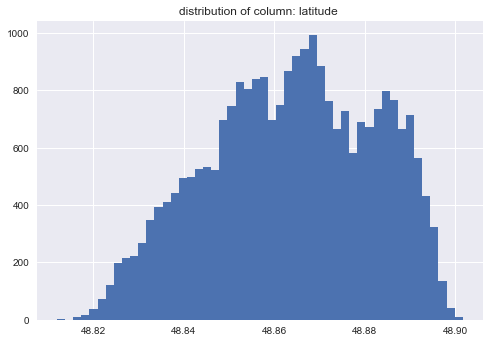

variable:  longitude


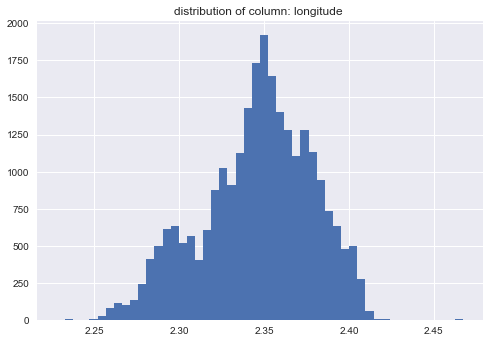

variable:  accommodates


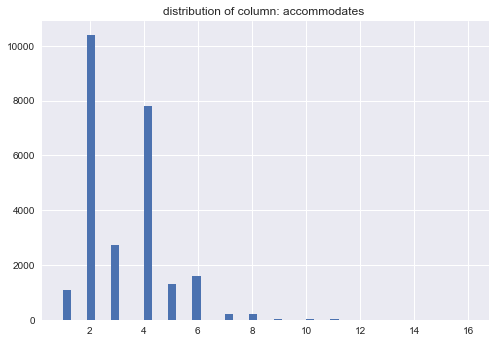

variable:  bathrooms


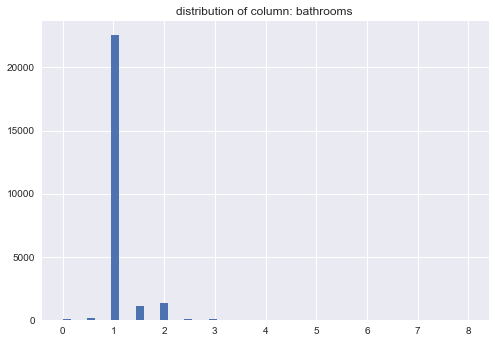

variable:  bedrooms


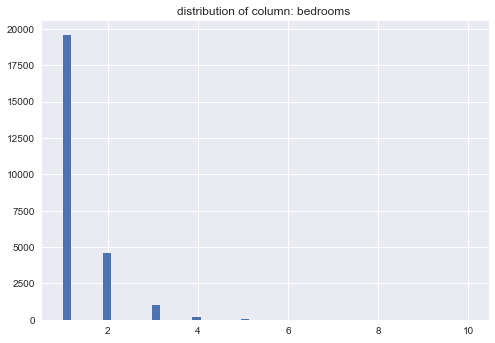

variable:  beds


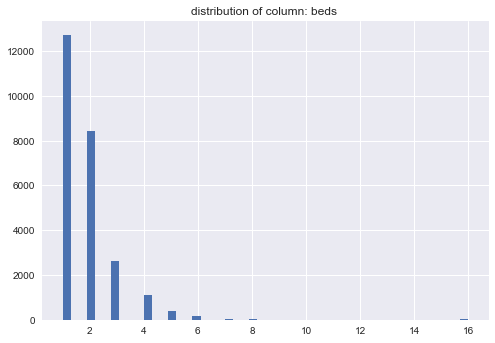

variable:  guests_included


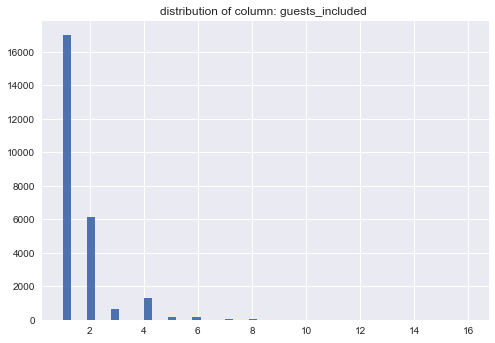

variable:  extra_people


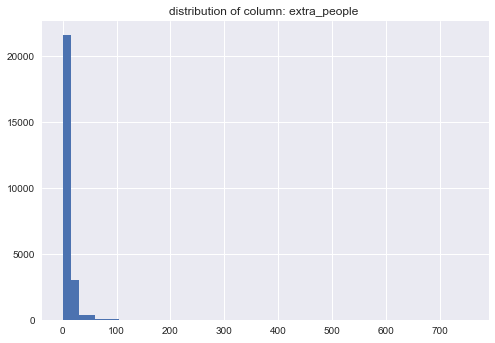

variable:  minimum_nights


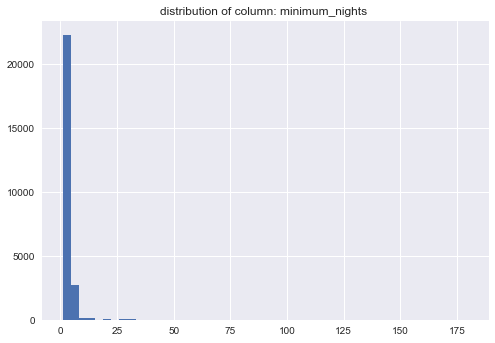

variable:  number_of_reviews


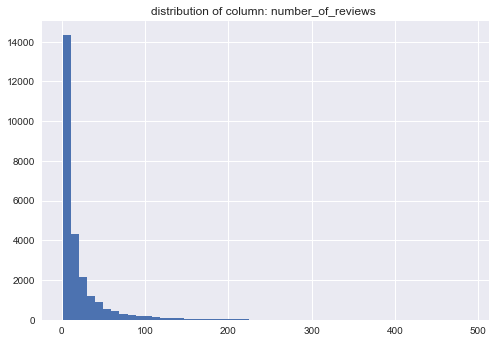

variable:  review_scores_rating


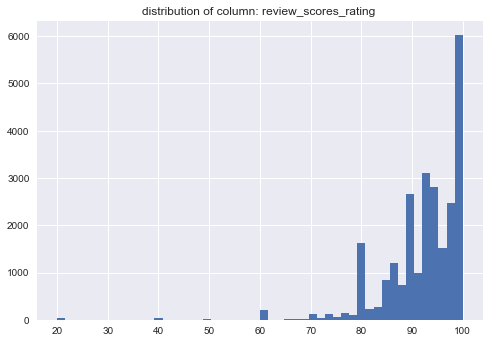

variable:  review_scores_accuracy


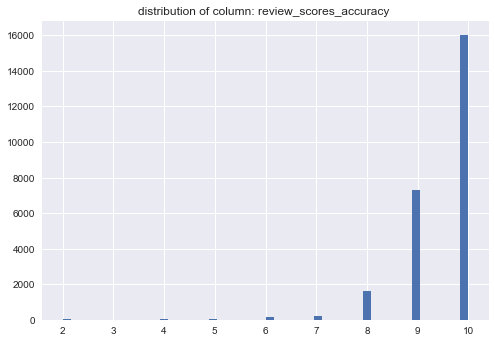

variable:  review_scores_cleanliness


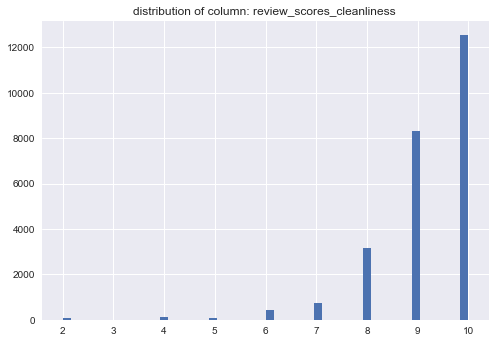

variable:  review_scores_checkin


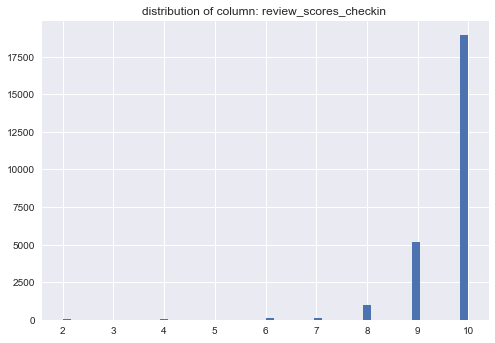

variable:  review_scores_communication


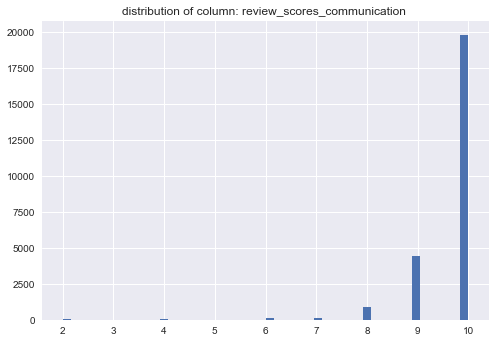

variable:  review_scores_location


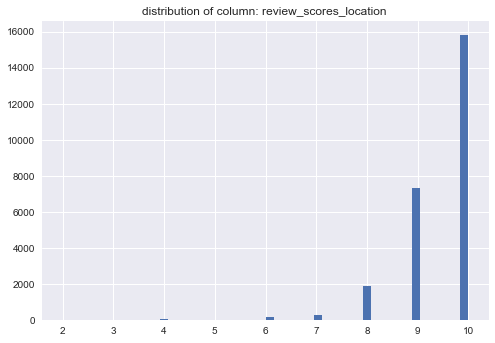

variable:  review_scores_value


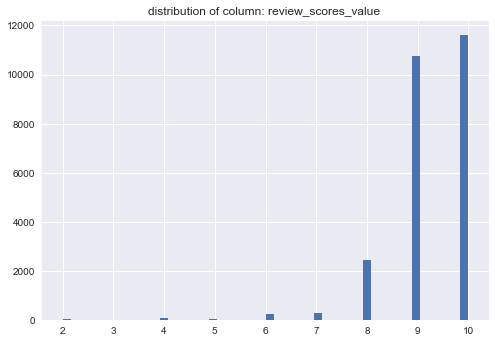

variable:  reviews_per_month


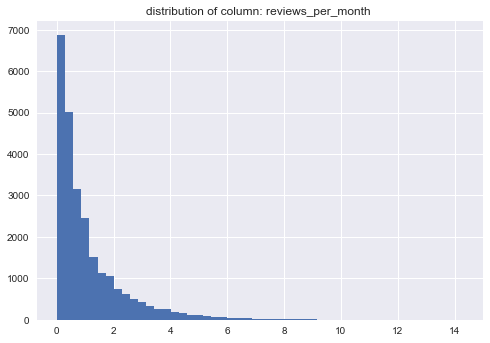

variable:  host_has_profile_pic_f


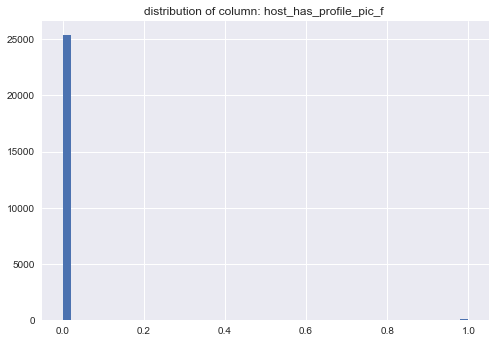

variable:  neighbourhood_cleansed_Buttes-Chaumont


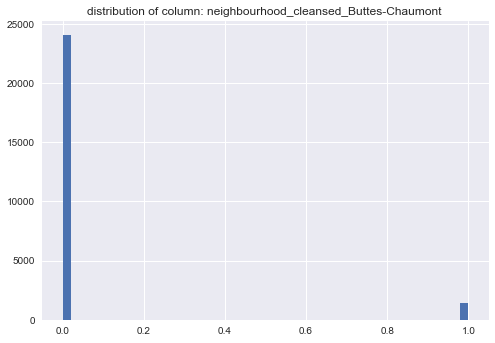

variable:  neighbourhood_cleansed_Reuilly


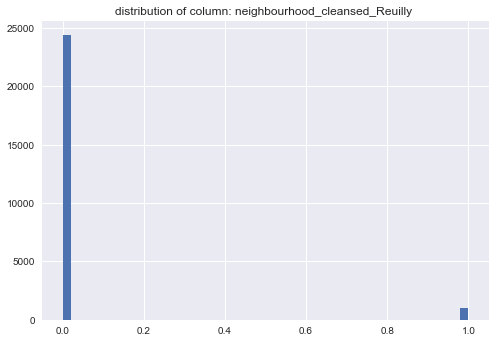

variable:  property_type_Apartment


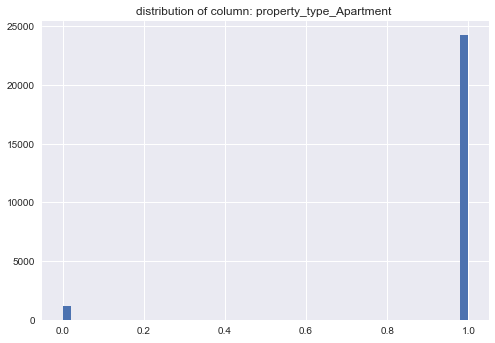

variable:  property_type_Bed & Breakfast


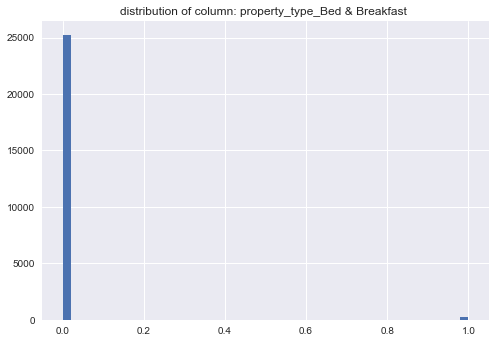

variable:  property_type_Boat


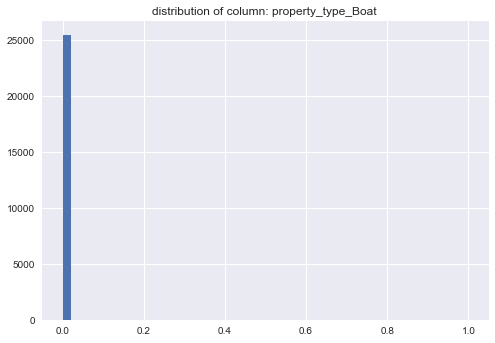

variable:  property_type_Boutique hotel


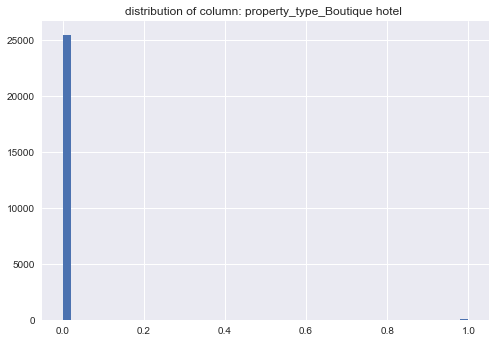

variable:  property_type_Bungalow


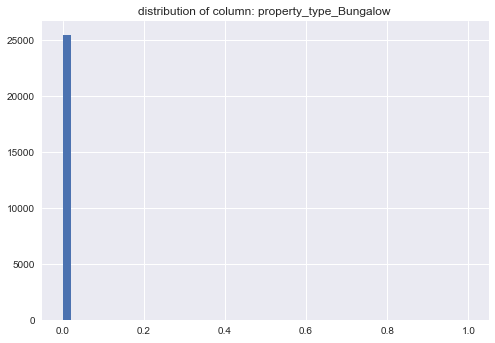

variable:  property_type_Dorm


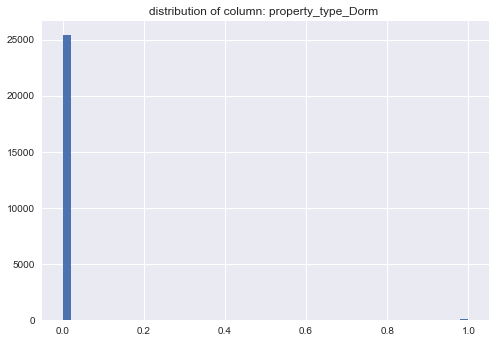

variable:  property_type_Guesthouse


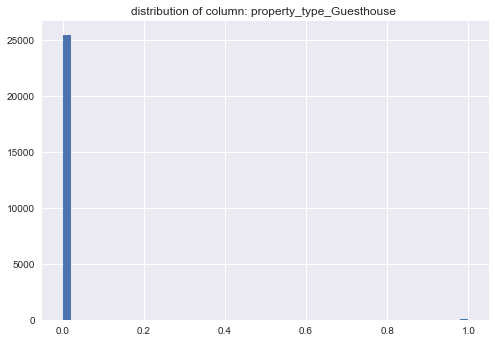

variable:  property_type_Hostel


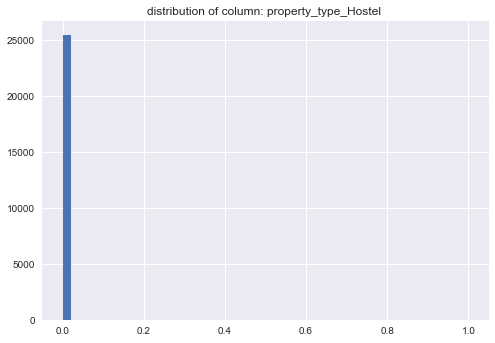

variable:  property_type_Serviced apartment


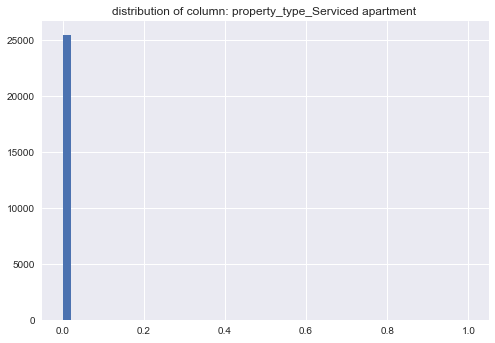

variable:  room_type_Entire home/apt


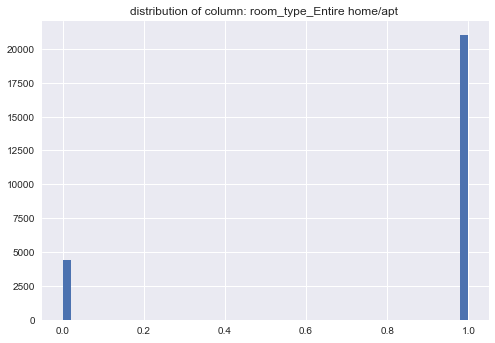

variable:  room_type_Private room


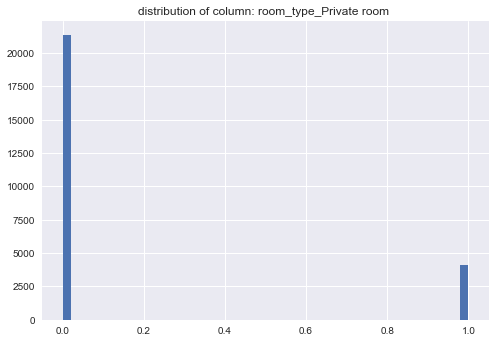

variable:  room_type_Shared room


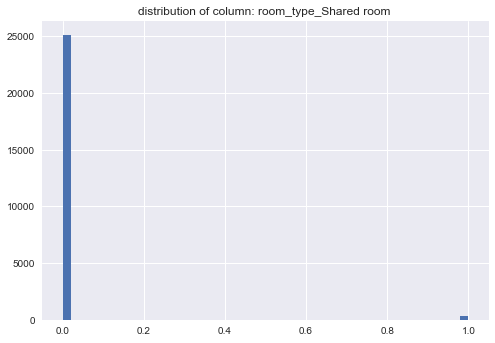

variable:  bed_type_Airbed


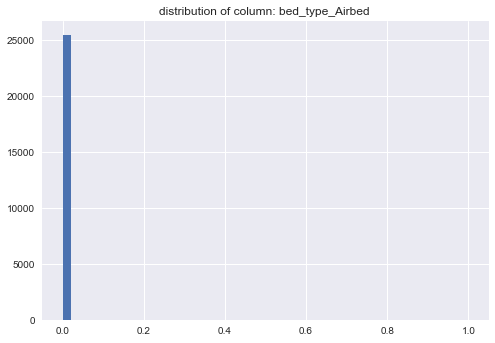

variable:  bed_type_Couch


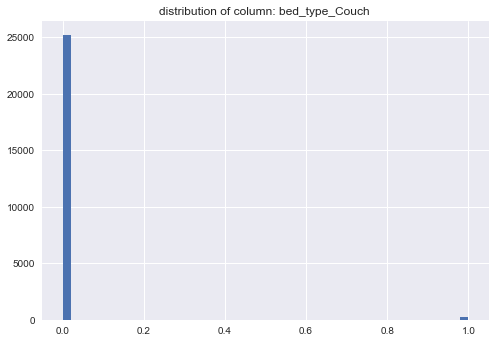

variable:  bed_type_Futon


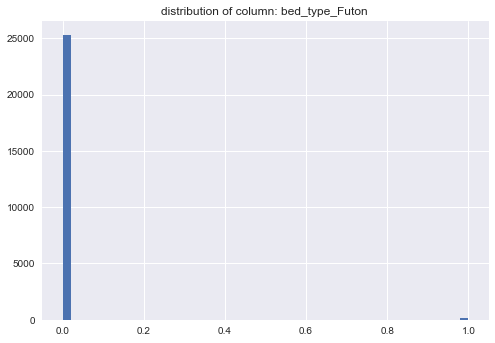

variable:  bed_type_Pull-out Sofa


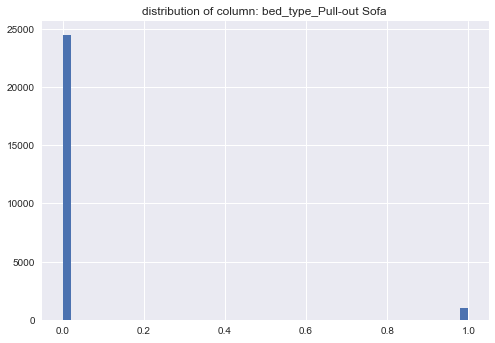

variable:  bed_type_Real Bed


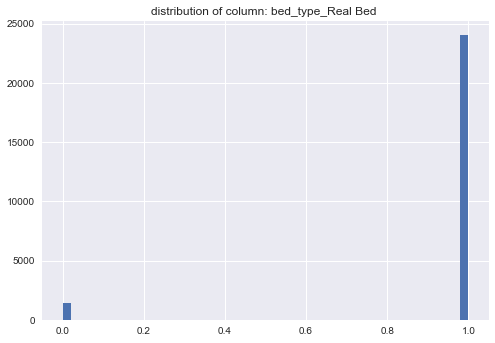

In [23]:
# draw histogram graph to see if we need to log some variables' values
for column in X_train_0.columns:
    print 'variable: ', column
    plt.figure()
    plt.hist(X_train_0[column], bins = 50)
    plt.title('distribution of column: %s ' % (column.decode('utf8')))
    plt.show()

# X_train_0.info()

After looking at the distribution graphs of each variables selected, we can see that the distribution of variable reviews_per_month is highly skewed to right. To better use this variable to predict the listing price, we log the distribution of this variable in the following code. 

In [24]:
cols_loged = [u'reviews_per_month']
for col in cols_loged:
    X_train_0[col]=np.log(X_train_0[col]+0.00001)

# X_train_0.head()

### 4.2 Preprocessing Data

Before using the data to create model, we preprocessed the data to make sure that all features/columns have a similar maganitude. This step is very important for clustering purposes, otherwise the clustering algorithm would only favor those largly-spaned columns (due to a larger distance measurement). 

We have tried two approach. The first one is MinMaxScale, where new_x = (x-x_min) / (x_max-x_min). The second one is normalization, where new_x = (x-mu)/std.

We only calculated the x_min, x_max, mu, std from TRAINING data, and then apply the transformation on both training and testing data. Because the size of training data is much bigger than test data, making the x_min, x_max, mu, std more believable. 

After trying these two methods to preprocess the data, we found that the latter preprocess method is better. 

In [25]:
# -------------------------------------------------------
# ----------------- Preprocessing The Data --------------
# -------------------------------------------------------

# in this project, we use MinMaxScale
from sklearn.preprocessing import Normalizer, StandardScaler

scale_method = 'min_max'

if scale_method == 'None':
    pass
else:
    if scale_method == 'min_max':
        scaler = StandardScaler()
    elif scale_method == 'mu_std':
        scaler = Normalizer()
    scaler.fit(X_train_0)
    X_train_0 = scaler.transform(X_train_0)
    X_test_0 = scaler.transform(X_test_0)

In [26]:
# -------------------------------------------------------
# ----------- Create, fit and evaluate The Model --------
# -------------------------------------------------------

# define the function to evaluate the model
# in this project, we use percentage tolerance rate to evaluate our model
def evalCorrect(y_true, y_pred, tol):
    assert (0<tol<1)
    y_low_bound = y_true.values* (1.0-tol)
    y_high_bound = y_true.values * (1.0+tol)
    correct = []
    
    for i in range(len(y_true)):
        if y_low_bound[i] <= y_pred[i] <= y_high_bound[i]:
            correct.append(1)
        else:
            correct.append(0)
    total_correct = np.sum(correct)
    accuracy = float(total_correct) / len(y_true)
    
    return accuracy

### 4.3 Accuracy Test

Instead of using the traditional way (MSE) of testing the efficiency of our regression model, we prefer to use percentage tolerance rate to evaluate our model. The process is demostrated below: 

If y_pred falls into [(1-tol_rate)* y_true, (1-tol_rate)* y_true], we consider this prediction CORRECT. Then, we can get the accuracy, which is the percentage of correct predictions. 

This is a better metric, since the discrepency between y_true and y_pred has a large span. For example, y_true = 10 and y_pred = 9, then error is -1. But if y_true = 1000, y_pred = 900, then error is -100. If you average (-1) with (-100), the effect of (-1) is going to be overweighted by (-100).Then the metric is only catered towards those very expensive listings. Therefore, the accuracy test is a better metric.

In this project, we will use 20% as tolerance interval.

Besides accuracy, we also give the median absolute error to evalute the performance of the model. 

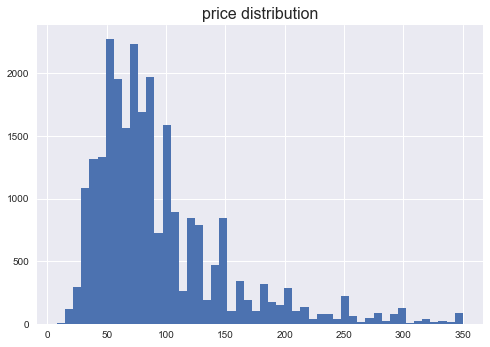

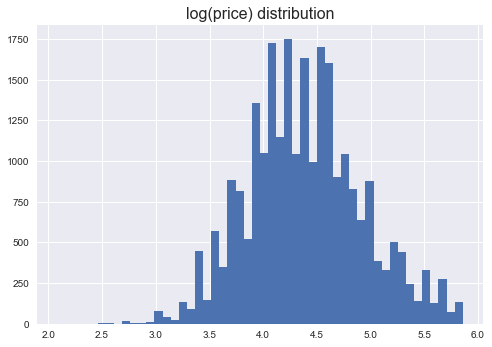

In [27]:
# considering the distribution of price, we would like to process the values of listing price
plt.figure()
plt.hist(y_train.values, bins=50)
plt.title('price distribution', fontsize=16)
plt.figure()
plt.hist(np.log(y_train.values), bins=50)
plt.title('log(price) distribution', fontsize=16)
plt.show()

According to the distribution graph of price, we found that it is highly skewly to right. This means that most of the listing prices are between 30 to 150. To better build a model to explan all the listing prices, we would like to use log(price).
After logging the listing price, we can see that the distribution of the price is kind of normalized. 

### 4.4 Model selection

The following coding is to check the performance of the models. Because it will take 5 to 10 minutes, we prefer to give the final results directly. Also we draw a bar graph to compare the performaces of these models. 

In [28]:
# check the accuracy of several models 

# tol = 0.2
# for model in ['least_square','ridge','knn']: # ['least_square', 'ridge', 'lasso', 'SVR', 'DecisionTree', 'knn']
#     print '\n'+'='*30
#     print 'model:', model
#     if model == 'least_square':
#         reg = linear_model.LinearRegression()
#     elif model == 'ridge':
#         alpha = 10 # play around with this number (alpha>0), plot test_error vs alpha
#         print "alpha:", alpha
#         reg = linear_model.Ridge(alpha)
#     elif model == 'lasso':
#         alpha = 5 # play around with this number (alpha>0), plot test_error vs alpha
#         print "alpha:", alpha
#         reg = linear_model.Lasso(alpha)
#     elif model == 'SVR':
#         from sklearn.svm import SVR
#         kernel = 'rbf' # ['rbf', 'linear', 'poly']
#         print 'kernel:', kernel
#         if kernel == 'linear':
#             reg = SVR(kernel='linear', C=1e1)
#         elif kernel == 'poly':
#             reg = SVR(kernel='poly', C=1e1, degree=2)
#         elif kernel == 'rbf':
#             reg = SVR(kernel='rbf', C=1e1, gamma=0.1)
#     elif model == 'DecisionTree':
#         from sklearn import tree
#         reg = tree.DecisionTreeRegressor()
#     elif model == 'knn':
#         from sklearn import neighbors
#         n_neighbors = 10
#         print 'n_neighbors:', n_neighbors
#         reg = neighbors.KNeighborsRegressor(n_neighbors, weights='distance')

#     # train the model
#     reg.fit(X_train_0, np.log(y_train))

#     # check training performance
#     y_train_pred = np.exp(reg.predict(X_train_0))
#     print "\ntrain_accu: %.3f" % evalCorrect(y_train, y_train_pred, tol)
# #     print "train_MAE: %.3f" % mean_absolute_error(y_train, y_train_pred)
#     print "train_R_square: %.3f" % r2_score(y_train, y_train_pred)

#     # check testing performance
#     y_test_pred = np.exp(reg.predict(X_test_0))
#     abs_err = np.abs(y_test_pred - y_test)
#     test_accu = evalCorrect(y_test, y_test_pred, tol)
#     print "\ntest_accu: %.3f" % test_accu
# #     print "test_MAE: %.3f" % mean_absolute_error(y_test, y_test_pred)
#     print "test median absolute error: %.3f" % np.median(abs_err)

#The following list are the stored result from our test. 
model = ['least_square','ridge(alpha: 5)', 'knn(n_neighbors: 5)','ridge(alpha: 10)', 'knn(n_neighbors: 10)']
test_accuracy= [0.460, 0.460, 0.469, 0.460, 0.479]
test_median_absolute_error = [16.829, 16.817, 16.822, 16.820, 16.459]

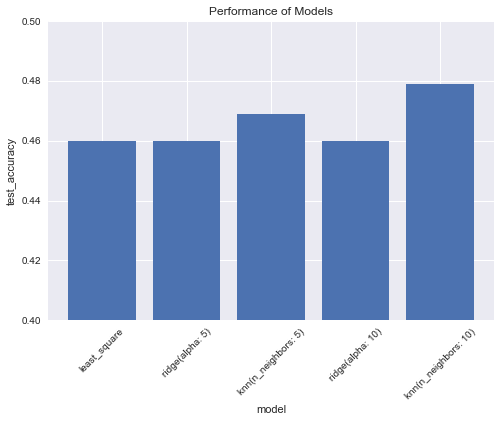

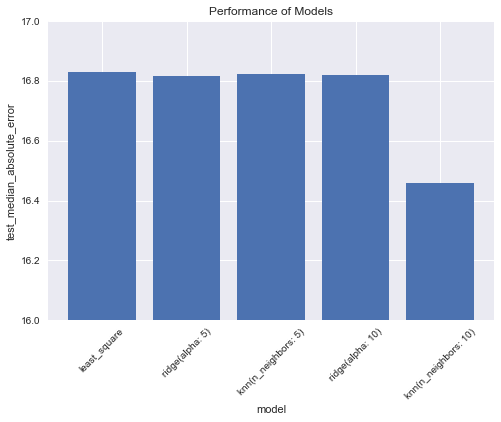

In [29]:
plt.bar(range(5),test_accuracy)
plt.xticks(range(5), model, rotation= 45)
plt.xlabel('model')
plt.ylabel('test_accuracy')
plt.ylim(0.4, 0.5)
plt.title('Performance of Models')
plt.show()

plt.bar(range(5), test_median_absolute_error)
plt.xticks(range(5), model, rotation= 45)
plt.xlabel('model')
plt.ylabel('test_median_absolute_error')
plt.ylim(16, 17)
plt.title('Performance of Models')
plt.show()

According to the graphs of performances of models( least_square, ridge(with alpha: 5 and 10) and knn models(with neighbours: 5 and 10)), we can see that the knn model has the best performance. Therefore, we decide to choose this model. 

With the knn model, we need to check which number of alpha is the best for this model.

The following code is using for loop to try knn model with different parameter neighbors. 

The following code will run about 10 to 20 minutes. So we directly give the results instead of running it. 

In [30]:
# choose the best alpha for the knn model
# list_neighbors = []
# list_test_accu = []
# list_median_absolute_error = []
# for n_neighbors in range(1, 20):
#     reg = neighbors.KNeighborsRegressor(n_neighbors, weights='distance')
#     reg.fit(X_train_0, np.log(y_train))
#     y_train_pred = np.exp(reg.predict(X_train_0))
#     y_test_pred = np.exp(reg.predict(X_test_0))
#     abs_err = np.abs(y_test_pred - y_test)
#     test_accu = evalCorrect(y_test, y_test_pred, tol)
#     list_neighbors.append(n_neighbors)
#     list_test_accu.append(test_accu)
#     list_median_absolute_error.append(np.median(abs_err))

# print list_neighbors
# print list_test_accu
# print list_median_absolute_error

#The following list are the stored result from our test.
list_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
list_test_accu = [0.39239113346958027, 0.43373683383115863, 0.45055808835088823, 0.4626631032856469, 0.4686370067599434, 0.4749253262065713, 0.47791227794371954, 0.47806948592988524, 0.47712623801289106, 0.4788555258607137, 0.4856154692658387, 0.48294293350102185, 0.4857726772520044, 0.4862443012105015, 0.4853010532935073, 0.48891683697531835, 0.48875962898915265, 0.4845150133626788, 0.4851438453073416]
list_median_absolute_error = [20.000000000000043, 18.599951192447193, 17.938759104149554, 17.195857402030569, 16.822445326497828, 16.556197301249853, 16.399878431070789, 16.295745388896037, 16.355326455471015, 16.458579584214903, 16.226361389805504, 16.114889522880077, 16.106321283512784, 16.076402634733327, 15.967856254765081, 15.995745573727845, 16.040746192981636, 16.155951277654594, 15.923774203736883]

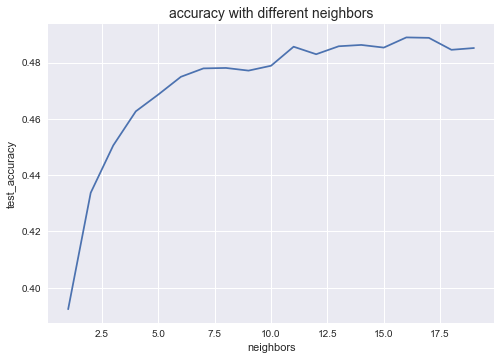

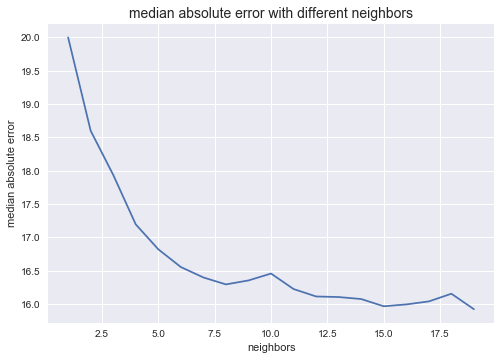

In [31]:
plt.plot(list_neighbors,list_test_accu)
plt.xlabel('neighbors')
plt.ylabel('test_accuracy')
plt.title('accuracy with different neighbors',fontsize =14)
plt.show()
plt.plot(list_neighbors,list_median_absolute_error)
plt.xlabel('neighbors')
plt.ylabel('median absolute error')
plt.title('median absolute error with different neighbors',fontsize =14)
plt.show()

According the trend line graphs above, we can see that the line becomes relatively flat starting from the neighbors of 6. This means that the performance of the model does not increase much after this point. Thereofore, we will use the knn model with the parameter neighbors of 6.

With the knn model with the parameter neighbor num of 6, the test accuracy is about 47%. Based on the calculation method of this model, which applies the clustering concept (simliar figures will results in similar prices), having more training data will increase the performance of this model. 


## 5. Keyword Analysis in Listing Titles

### 5.1 Keyword Selection

Words and descriptions in titles of each Airbnb listing are the first things that customers see when they visit the site. We decide to look into whether words on listing title will have an affect on the booking rate of each listing.

We used text mining techniques in order to identify the common words and phrases used in Airbnb titles.

In [32]:
columns3=['id',"beds","bathrooms","minimum_nights","number_of_reviews","review_scores_rating","latitude","longitude","name"]
#Importing the file for descriptions and other texts
textmine=pd.read_csv('X_train.csv',usecols=columns3)  
#Importing the library for keyword count
from sklearn.feature_extraction.text import CountVectorizer 
word_vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(textmine['name'])
frequencies = sum(sparse_matrix).toarray()[0]
text_mine=pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

text_mine=text_mine.reset_index()
text_mine=text_mine.sort_values(['frequency'],ascending=False)
#Showing the dataframe with keywords and their frequencies
text_mine.head(5) 

index  frequency
3801        paris       6280
2916           in       4945
2490         flat       3997
1049    apartment       2871
1067  appartement       2787

We chose top 25 relevant words from the analysis above and organized them to see if there is an obvious trend related to the booking percentage of a listing.

In [33]:
columns4=['id',"beds","bathrooms","price","minimum_nights","number_of_reviews","review_scores_rating","latitude","longitude","name"]
#reading the file
final_text=pd.read_csv("final train data.csv",usecols=columns4)

In [34]:
#create a list with all keywords
cols_selected_text = ['cosy','montmartre','charming','marais','eiffel','chambre',\
                     'lovely','heart','nice','center','canal','bastille','view',\
                     'charmant','parisian','beautiful','saint','central','bright',\
                     'champs','spacious','private','close','balcony','modern']
#run for loop to extract all data with the selected key word
for col in cols_selected_text:
    final_text[col]=0
    final_text.loc[final_text['name'].str.contains(col),col]=1

In [35]:
#Summing up all the columns generated above to see the total number of keywords in the main description
final_text['final_count']=final_text['modern']+final_text['balcony']+final_text['close']+final_text['private']+final_text['spacious']+ final_text['champs']+  final_text['bright']+   final_text['central']+final_text['saint']+final_text['beautiful']+final_text['parisian']+final_text['charmant']+final_text['view']+final_text['bastille']+final_text['canal']+final_text['center']+final_text['nice']+final_text['heart']+final_text['lovely']+final_text['chambre']+final_text['eiffel']+final_text['marais']+ final_text['charming']+final_text['montmartre']+final_text['cosy']                                                                                                                                                                         

In [36]:
#Droppping all the NA Values if any
final_text.dropna(subset=columns4)
#Renamaing the column name before merging
final_text.rename(columns={'id': 'listing_id'}, inplace=True) 

In [33]:
#Merging both the dataframes
final1_text=pd.merge(final_text,cal1,on='listing_id',how='inner') 
#Calculating the mean booking percentage for all the bins
final2_text = final1_text.groupby("final_count", as_index=False).perc.mean()
#Converting it into a dataframe
final3_text = pd.DataFrame(final2_text)  
#Sorting the index
final3_text=  final3_text.sort_index(by=['perc'], ascending=[False])
final3_text = pd.DataFrame(final2_text)

NameError: name 'cal1' is not defined

In [ ]:
#Converting the fraction into %
final3_text["perc"]=final3_text["perc"]*100 
#Plotting the graph
sns.barplot(x="final_count", y="perc", data=final3_text)
sns.plt.show() 

### 5.2 Results of the Graph:
The horizontal axis stands for the amount of positive key words that are in the listings. The vertical axis stands for the average booking rate of the listings in each group. As displayed in the graph, there is a moderate positive trend between the amount of key words and the booking rates. The booking rate increases as the number of key words increases in the title of the Airbnb listing. Therefore, this is an area where we can further invest on to enhance the booking rates of our hosts.

# 6. Conclusion
According to our analysis, both numerical and categorical variables have important influences on the price. After the initiative analysis of the data from the market of Paris, we've managed to formulate a price predictive model that has a accuracy of 48%, and we expect the accuracy to increase with further collection of data. However, none of the variables has significant influence on the price individually. Additionally, during our model selection process, the 3 models we have experimented with don't have obvious performance difference. 

From our exploratory analysis on location, lisinting titles, we learned that more attributes are correlated to price variation. To achieve greater accuracy in the future, we suggest to further investigate on other factors such as distance to local transportation stations, demand and price patterns, and the local competition of hotels. In the end, we hope to finalize a feature on the website that can recommend accurate prices to efficiently raise the booking rate of each active listing and return higher profit to our company.

In the future, our vision is that active Airbnb hosts can all have access to precises market price suggestions, and these prices should be flexible to attract customers in different scenarios.